# **Mask R-CNN pipeline for detecting river vessels on the Mekong Delta**

### 1. Preparation

In [1]:
# Set to current working directory
%cd E:/Anaconda/Mask_RCNN

E:\Anaconda\Mask_RCNN


In [25]:
# Import libraries
import os
import sys
import json
import numpy as np
import time
import zipfile
from PIL import Image, ImageDraw
import datetime
import logging
from tensorflow.keras.callbacks import EarlyStopping
from imgaug import augmenters as iaa
import skimage.draw
import skimage.io
import skimage
import matplotlib
import cv2


In [3]:
# Unzip trainingdata and place it in root directory
with zipfile.ZipFile('E:/Anaconda/Mask_RCNN/Mekong_Thesis_Data/Annotationdata.zip', 'r') as zip_ref:
    zip_ref.extractall('E:/Anaconda/Mask_RCNN')

with zipfile.ZipFile('E:/Anaconda/Mask_RCNN/Mekong_Thesis_Data/test.zip', 'r') as zip_ref:    
    zip_ref.extractall('E:/Anaconda/Mask_RCNN')

In [4]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'E:/Anaconda/Mask_RCNN'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):    
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
# Set dataset source to a variable
dataset_dir = 'E:/Anaconda/Mask_RCNN/Annotationdata/'

Change the configurations class of the coco dataset to fit with the Mekong dataset

In [6]:
"""
Mask R-CNN
Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

############################################################
#  Configurations
############################################################


class MekongConfig(Config):
    """Configuration for training on the Mekong river vessel dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Mekong"

    # I used a GPU with 16GB RAM
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # Background + 4 boat classes

    # Number of training steps per epoch
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320

    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.6
    TRAIN_ROIS_PER_IMAGE = 50
    STEPS_PER_EPOCH = 400
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    MINI_MASK_SHAPE = (320, 320)

############################################################
#  Dataset
############################################################

class MekongDataset(utils.Dataset):

    def load_Mekong(self, dataset_dir, subset):
        """Load a subset of the Mekong dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("Mekong", 1, "boat")
        self.add_class("Mekong", 2, "barge")
        self.add_class("Mekong", 3, "clusterboat")
        self.add_class("Mekong", 4, "container")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        if subset == 'train':
            annotations1 = json.load(open('E:/Anaconda/Mask_RCNN/Annotationdata_alt/train/via_region_data_json.json'))
        else:
            annotations1 = json.load(open('E:/Anaconda/Mask_RCNN/Annotationdata_alt/val/via_region_data_json.json'))

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data_json.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            #if type(a['regions']) is dict:
                #polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #else:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes'] for s in a['regions']]
            num_ids = []
            for n in objects:
                
                try:
                    if n['class'] == 'boat':
                        num_ids.append(1)
                    elif n['class'] == 'barge':
                        num_ids.append(2)
                    elif n['class'] == 'clusterboat':
                        num_ids.append(3)
                    elif n['class'] == 'container':
                        num_ids.append(4)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path) 
            height, width = image.shape[:2]

            self.add_image(
                "Mekong",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons,
                num_ids=num_ids,
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Mekong dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "Mekong":
            return super(self.__class__, self).load_mask(image_id)
        

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "Mekong":
          return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr-1, cc-1, i] = 1


        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)


        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Mekong":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

config = MekongConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Training the dataset

In [7]:
dataset_train = MekongDataset()
dataset_train.load_Mekong('E:/Anaconda/Mask_RCNN/Annotationdata_alt/', 'train')
dataset_train.prepare()

dataset_val = MekongDataset()
dataset_val.load_Mekong('E:/Anaconda/Mask_RCNN/Annotationdata_alt/', 'val')
dataset_val.prepare()

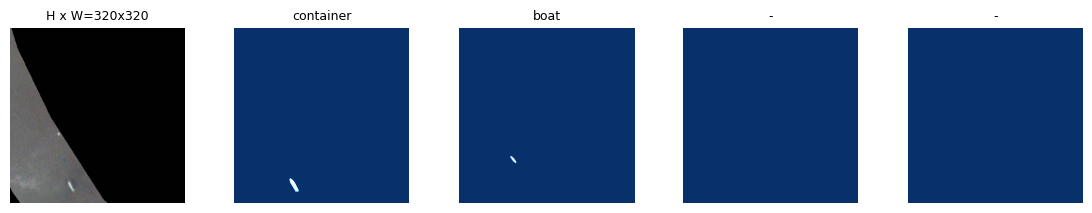

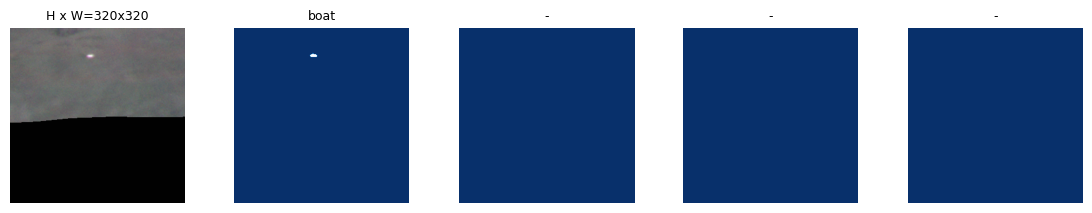

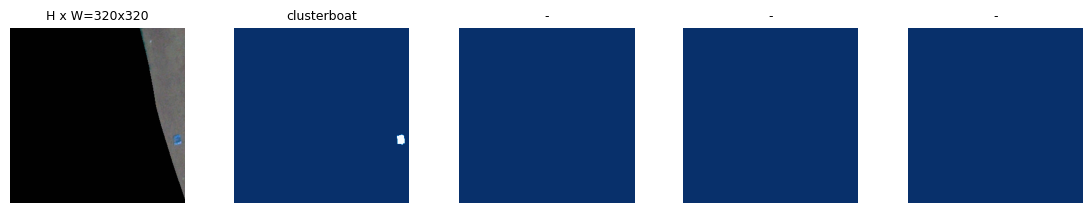

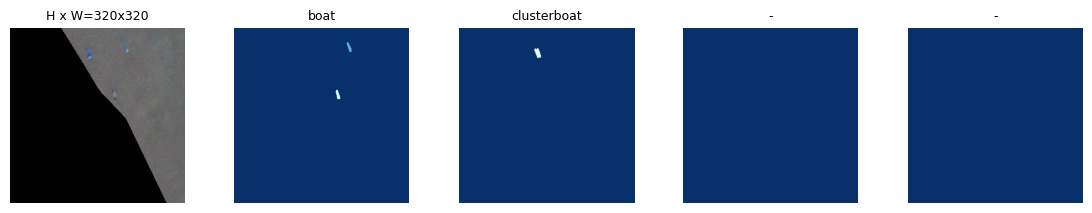

In [8]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [9]:
# Create model in training mode
config = MekongConfig()
model = modellib.MaskRCNN(mode="training",config=config,
                          model_dir=DEFAULT_LOGS_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 324
Classes: ['BG', 'boat', 'barge', 'clusterboat', 'container']


In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [12]:
# Early stopping callback set to monitor vall loss. If the model starts to overfit the early stopping callback is triggered
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)

# Image augmentation to enhance the dataset
augmentation = iaa.SomeOf((0, 3), [
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.OneOf([iaa.Affine(rotate=90),
                 iaa.Affine(rotate=180),
                 iaa.Affine(rotate=270)]),
      iaa.Multiply((0.8, 1.5)),
      iaa.GaussianBlur(sigma=(0.0, 5.0))
  ])

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
print("Training network heads")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads',
            custom_callbacks=[early_stopping_callback],
            augmentation = augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: E:/Anaconda/Mask_RCNN\logs\mekong20230417T1249\mask_rcnn_mekong_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/30
 58/400 [===>..........................] - ETA: 1:27 - loss: 3.4121 - rpn_class_loss: 0.1450 - rpn_bbox_loss: 1.8060 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.6857 - mrcnn_mask_loss: 0.5457

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


143/400 [=========>....................] - ETA: 49s - loss: 2.8814 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 1.2819 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.7170 - mrcnn_mask_loss: 0.5721

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 69s 172ms/step - loss: 2.5850 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.0655 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.6607 - mrcnn_mask_loss: 0.5486 - val_loss: 2.2639 - val_rpn_class_loss: 0.0500 - val_rpn_bbox_loss: 0.8709 - val_mrcnn_class_loss: 0.3869 - val_mrcnn_bbox_loss: 0.4722 - val_mrcnn_mask_loss: 0.4840

Epoch 2/30
 35/400 [=>............................] - ETA: 51s - loss: 2.1080 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 0.7883 - mrcnn_class_loss: 0.2837 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.4742

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


144/400 [=========>....................] - ETA: 36s - loss: 2.1595 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.5164 - mrcnn_mask_loss: 0.4719

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 63s 156ms/step - loss: 2.1115 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.7796 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.5092 - mrcnn_mask_loss: 0.4680 - val_loss: 2.0990 - val_rpn_class_loss: 0.0454 - val_rpn_bbox_loss: 0.7517 - val_mrcnn_class_loss: 0.3812 - val_mrcnn_bbox_loss: 0.4692 - val_mrcnn_mask_loss: 0.4514
Epoch 3/30
 39/400 [=>............................] - ETA: 47s - loss: 2.0488 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7562 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.5350 - mrcnn_mask_loss: 0.4517

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


141/400 [=========>....................] - ETA: 35s - loss: 2.0851 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.4588

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


246/400 [=================>............] - ETA: 21s - loss: 2.0052 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7552 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4446

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


277/400 [===================>..........] - ETA: 17s - loss: 1.9976 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7572 - mrcnn_class_loss: 0.2868 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.4365

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 61s 152ms/step - loss: 1.9814 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7296 - mrcnn_class_loss: 0.2913 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4437 - val_loss: 1.9674 - val_rpn_class_loss: 0.0387 - val_rpn_bbox_loss: 0.7770 - val_mrcnn_class_loss: 0.3832 - val_mrcnn_bbox_loss: 0.3755 - val_mrcnn_mask_loss: 0.3929
Epoch 4/30
344/400 [========================>.....] - ETA: 7s - loss: 1.8649 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6541 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.4457 - mrcnn_mask_loss: 0.4227

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


373/400 [==========================>...] - ETA: 3s - loss: 1.8571 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6497 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.4452 - mrcnn_mask_loss: 0.4238

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 154ms/step - loss: 1.8673 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6522 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.4463 - mrcnn_mask_loss: 0.4246 - val_loss: 1.8773 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.6738 - val_mrcnn_class_loss: 0.4091 - val_mrcnn_bbox_loss: 0.3894 - val_mrcnn_mask_loss: 0.3717
Epoch 5/30
 55/400 [===>..........................] - ETA: 47s - loss: 1.8546 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6520 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4576

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


229/400 [================>.............] - ETA: 23s - loss: 1.8408 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6380 - mrcnn_class_loss: 0.2912 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.4385

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 154ms/step - loss: 1.8026 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6200 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4227 - val_loss: 1.7648 - val_rpn_class_loss: 0.0316 - val_rpn_bbox_loss: 0.6362 - val_mrcnn_class_loss: 0.3691 - val_mrcnn_bbox_loss: 0.3577 - val_mrcnn_mask_loss: 0.3703
Epoch 6/30
 96/400 [======>.......................] - ETA: 40s - loss: 1.6949 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5662 - mrcnn_class_loss: 0.2792 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.4148

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


201/400 [==============>...............] - ETA: 27s - loss: 1.7018 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.5916 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.4087

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 155ms/step - loss: 1.7203 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.5949 - mrcnn_class_loss: 0.2909 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.4130 - val_loss: 1.7169 - val_rpn_class_loss: 0.0339 - val_rpn_bbox_loss: 0.6232 - val_mrcnn_class_loss: 0.3300 - val_mrcnn_bbox_loss: 0.3531 - val_mrcnn_mask_loss: 0.3767
Epoch 7/30
 58/400 [===>..........................] - ETA: 46s - loss: 1.6395 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.3981

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


148/400 [==========>...................] - ETA: 34s - loss: 1.7152 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.5793 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.4217

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


231/400 [================>.............] - ETA: 23s - loss: 1.6920 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5720 - mrcnn_class_loss: 0.2722 - mrcnn_bbox_loss: 0.4061 - mrcnn_mask_loss: 0.4135

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


258/400 [==================>...........] - ETA: 20s - loss: 1.6974 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5733 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.4160

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 154ms/step - loss: 1.6668 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.4036 - val_loss: 1.7109 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 0.5580 - val_mrcnn_class_loss: 0.3979 - val_mrcnn_bbox_loss: 0.3543 - val_mrcnn_mask_loss: 0.3756
Epoch 8/30
249/400 [=================>............] - ETA: 21s - loss: 1.6264 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.2908 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.3915

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


396/400 [============================>.] - ETA: 0s - loss: 1.6275 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.3806 - mrcnn_mask_loss: 0.3936

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 156ms/step - loss: 1.6272 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.3797 - mrcnn_mask_loss: 0.3934 - val_loss: 1.6722 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 0.6090 - val_mrcnn_class_loss: 0.3381 - val_mrcnn_bbox_loss: 0.3324 - val_mrcnn_mask_loss: 0.3615
Epoch 9/30
 51/400 [==>...........................] - ETA: 48s - loss: 1.5181 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.3743

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


216/400 [===============>..............] - ETA: 26s - loss: 1.5428 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5084 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.3718

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 155ms/step - loss: 1.5665 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.3813 - val_loss: 1.6293 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.5471 - val_mrcnn_class_loss: 0.3518 - val_mrcnn_bbox_loss: 0.3470 - val_mrcnn_mask_loss: 0.3548
Epoch 10/30
 42/400 [==>...........................] - ETA: 46s - loss: 1.4889 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4809 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.3788

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


280/400 [====================>.........] - ETA: 17s - loss: 1.5594 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5077 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.3619 - mrcnn_mask_loss: 0.3812

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 63s 158ms/step - loss: 1.5482 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5043 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.3805 - val_loss: 1.6021 - val_rpn_class_loss: 0.0330 - val_rpn_bbox_loss: 0.5643 - val_mrcnn_class_loss: 0.3448 - val_mrcnn_bbox_loss: 0.3248 - val_mrcnn_mask_loss: 0.3351
Epoch 11/30
  8/400 [..............................] - ETA: 57s - loss: 1.6585 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.4160

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 43/400 [==>...........................] - ETA: 52s - loss: 1.5245 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.3599

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


358/400 [=========================>....] - ETA: 5s - loss: 1.5114 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4896 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.3799

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 154ms/step - loss: 1.4931 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.3794 - val_loss: 1.5066 - val_rpn_class_loss: 0.0223 - val_rpn_bbox_loss: 0.5060 - val_mrcnn_class_loss: 0.3185 - val_mrcnn_bbox_loss: 0.3107 - val_mrcnn_mask_loss: 0.3491
Epoch 12/30
 64/400 [===>..........................] - ETA: 46s - loss: 1.4977 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.3665

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


171/400 [===========>..................] - ETA: 32s - loss: 1.3994 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4618 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.3565

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


207/400 [==============>...............] - ETA: 28s - loss: 1.4408 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.3618

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 154ms/step - loss: 1.4764 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.3701 - val_loss: 1.6345 - val_rpn_class_loss: 0.0304 - val_rpn_bbox_loss: 0.6183 - val_mrcnn_class_loss: 0.3407 - val_mrcnn_bbox_loss: 0.3164 - val_mrcnn_mask_loss: 0.3288
Epoch 13/30
 73/400 [====>.........................] - ETA: 45s - loss: 1.4378 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.3713

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


309/400 [======================>.......] - ETA: 13s - loss: 1.4275 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.4583 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.3759

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 155ms/step - loss: 1.4391 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.3760 - val_loss: 1.5296 - val_rpn_class_loss: 0.0315 - val_rpn_bbox_loss: 0.5831 - val_mrcnn_class_loss: 0.3148 - val_mrcnn_bbox_loss: 0.2922 - val_mrcnn_mask_loss: 0.3081
Epoch 14/30
 90/400 [=====>........................] - ETA: 45s - loss: 1.4273 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4786 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.3732

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


144/400 [=========>....................] - ETA: 37s - loss: 1.4522 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.4770 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.3803

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 155ms/step - loss: 1.4085 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.4749 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 0.3645 - val_loss: 1.4116 - val_rpn_class_loss: 0.0255 - val_rpn_bbox_loss: 0.4839 - val_mrcnn_class_loss: 0.2941 - val_mrcnn_bbox_loss: 0.2847 - val_mrcnn_mask_loss: 0.3234
Epoch 15/30
  1/400 [..............................] - ETA: 50s - loss: 1.2355 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.5340 - mrcnn_bbox_loss: 0.4502 - mrcnn_mask_loss: 0.1935

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 14/400 [>.............................] - ETA: 57s - loss: 1.2336 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.3407

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


310/400 [======================>.......] - ETA: 12s - loss: 1.3436 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.3572

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 63s 159ms/step - loss: 1.3705 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4350 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.3584 - val_loss: 1.5221 - val_rpn_class_loss: 0.0241 - val_rpn_bbox_loss: 0.5316 - val_mrcnn_class_loss: 0.3377 - val_mrcnn_bbox_loss: 0.2991 - val_mrcnn_mask_loss: 0.3296
Epoch 16/30
 25/400 [>.............................] - ETA: 53s - loss: 1.1896 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3285 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.3561

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


204/400 [==============>...............] - ETA: 28s - loss: 1.2939 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4023 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.3624

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 63s 157ms/step - loss: 1.3291 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4176 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3632 - val_loss: 1.4252 - val_rpn_class_loss: 0.0236 - val_rpn_bbox_loss: 0.4742 - val_mrcnn_class_loss: 0.3098 - val_mrcnn_bbox_loss: 0.3036 - val_mrcnn_mask_loss: 0.3140
Epoch 17/30
 68/400 [====>.........................] - ETA: 47s - loss: 1.4214 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.3669

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


173/400 [===========>..................] - ETA: 33s - loss: 1.2785 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.3952 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.2853 - mrcnn_mask_loss: 0.3538

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


273/400 [===================>..........] - ETA: 19s - loss: 1.3375 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4192 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.3619

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 64s 161ms/step - loss: 1.3689 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.3621 - val_loss: 1.5325 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 0.5709 - val_mrcnn_class_loss: 0.3013 - val_mrcnn_bbox_loss: 0.3067 - val_mrcnn_mask_loss: 0.3251
Epoch 18/30
113/400 [=======>......................] - ETA: 39s - loss: 1.3620 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.3526

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


306/400 [=====================>........] - ETA: 13s - loss: 1.3545 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.3656

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 62s 155ms/step - loss: 1.3509 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.3625 - val_loss: 1.4548 - val_rpn_class_loss: 0.0230 - val_rpn_bbox_loss: 0.4911 - val_mrcnn_class_loss: 0.3164 - val_mrcnn_bbox_loss: 0.2880 - val_mrcnn_mask_loss: 0.3363
Training took 19.63 minutes


In [15]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=60, 
            layers="all",
            custom_callbacks=[early_stopping_callback],
            augmentation = augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 30. LR=0.0001

Checkpoint Path: E:/Anaconda/Mask_RCNN\logs\mekong20230417T1249\mask_rcnn_mekong_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 31/60
 41/400 [==>...........................] - ETA: 4:20 - loss: 1.2613 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.3380

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 56/400 [===>..........................] - ETA: 3:22 - loss: 1.2327 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.3572 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.3330

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 112s 281ms/step - loss: 1.2073 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.3724 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2620 - mrcnn_mask_loss: 0.3349 - val_loss: 1.3656 - val_rpn_class_loss: 0.0233 - val_rpn_bbox_loss: 0.4835 - val_mrcnn_class_loss: 0.2952 - val_mrcnn_bbox_loss: 0.2645 - val_mrcnn_mask_loss: 0.2992
Epoch 32/60
184/400 [============>.................] - ETA: 45s - loss: 1.1858 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2615 - mrcnn_mask_loss: 0.3320

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


199/400 [=============>................] - ETA: 42s - loss: 1.1876 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.3530 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.3341

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


332/400 [=======================>......] - ETA: 14s - loss: 1.2076 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.3639 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.2672 - mrcnn_mask_loss: 0.3347

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 89s 223ms/step - loss: 1.1991 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.3358 - val_loss: 1.2684 - val_rpn_class_loss: 0.0218 - val_rpn_bbox_loss: 0.4576 - val_mrcnn_class_loss: 0.2478 - val_mrcnn_bbox_loss: 0.2444 - val_mrcnn_mask_loss: 0.2967
Epoch 33/60
 78/400 [====>.........................] - ETA: 1:10 - loss: 1.2602 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3544 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.3557

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


213/400 [==============>...............] - ETA: 40s - loss: 1.2321 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2747 - mrcnn_mask_loss: 0.3459

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 91s 227ms/step - loss: 1.1797 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.3524 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.2610 - mrcnn_mask_loss: 0.3404 - val_loss: 1.4081 - val_rpn_class_loss: 0.0302 - val_rpn_bbox_loss: 0.5281 - val_mrcnn_class_loss: 0.2887 - val_mrcnn_bbox_loss: 0.2598 - val_mrcnn_mask_loss: 0.3012
Epoch 34/60
 36/400 [=>............................] - ETA: 1:21 - loss: 1.0873 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.3044 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.3206

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


284/400 [====================>.........] - ETA: 24s - loss: 1.1159 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.3488 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.3222

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


387/400 [============================>.] - ETA: 2s - loss: 1.1216 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.3443 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.3271

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 90s 225ms/step - loss: 1.1283 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3455 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.3269 - val_loss: 1.3387 - val_rpn_class_loss: 0.0229 - val_rpn_bbox_loss: 0.4788 - val_mrcnn_class_loss: 0.2796 - val_mrcnn_bbox_loss: 0.2621 - val_mrcnn_mask_loss: 0.2952
Epoch 35/60
 77/400 [====>.........................] - ETA: 1:10 - loss: 1.1567 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.3347 - mrcnn_class_loss: 0.2079 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.3389

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


318/400 [======================>.......] - ETA: 17s - loss: 1.1143 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.3325 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.3303

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 90s 225ms/step - loss: 1.1257 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.3398 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.3330 - val_loss: 1.3950 - val_rpn_class_loss: 0.0256 - val_rpn_bbox_loss: 0.5166 - val_mrcnn_class_loss: 0.2859 - val_mrcnn_bbox_loss: 0.2630 - val_mrcnn_mask_loss: 0.3040
Epoch 36/60
 38/400 [=>............................] - ETA: 1:12 - loss: 1.0442 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.1730 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.3230

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


181/400 [============>.................] - ETA: 46s - loss: 1.1401 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.3387 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.3332

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


312/400 [======================>.......] - ETA: 18s - loss: 1.1209 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.3289

C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (320, 320, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


400/400 [==============================] - 90s 226ms/step - loss: 1.1317 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.3314 - val_loss: 1.2812 - val_rpn_class_loss: 0.0235 - val_rpn_bbox_loss: 0.4743 - val_mrcnn_class_loss: 0.2542 - val_mrcnn_bbox_loss: 0.2448 - val_mrcnn_mask_loss: 0.2844
Training took 9.68 minutes


### Evaluating the model

In [13]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320
    DETECTION_MIN_CONFIDENCE = 0.65
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.65
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [14]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)



Instructions for updating:
Use `tf.cast` instead.


In [16]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights 
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:/Anaconda/Mask_RCNN\logs\mekong20230412T1202\mask_rcnn_mekong_0045.h5
Re-starting from epoch 45


In [17]:
# Compute VOC-style Average Precision
def evaluate_model(image_ids):
    APs = []
    Precision = []
    Recall = []
    Overlap = []
    F1_scores = []
    for image_id in dataset_val.image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))
        APs.append(AP)
        Precision.append(np.mean(precisions))
        Recall.append(np.mean(recalls))
        Overlap.append(overlaps)
    return APs, Precision, Recall, Overlap, F1_scores

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
APs, Precision, Recall, Overlap, F1_scores = evaluate_model(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.9022352380583984


In [18]:
print("f1-score: ", np.mean(F1_scores))

f1-score:  0.6591272197276439


In [19]:
print("the precision is", np.mean(Precision))

the precision is 0.7926839426839427


In [20]:
print("the recall is", np.mean(Recall))

the recall is 0.5767587144064884


In [21]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    import matplotlib.pyplot as plt
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image_id  273 E:/Anaconda/Mask_RCNN/Annotationdata_alt/train\Mekong_2021.12.14_101f_merge_07_04_RGB.png
image                    shape: (320, 320, 3)         min:    1.00000  max:  240.00000  uint8
mask                     shape: (320, 320, 5)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:   10.00000  max:  271.00000  int32


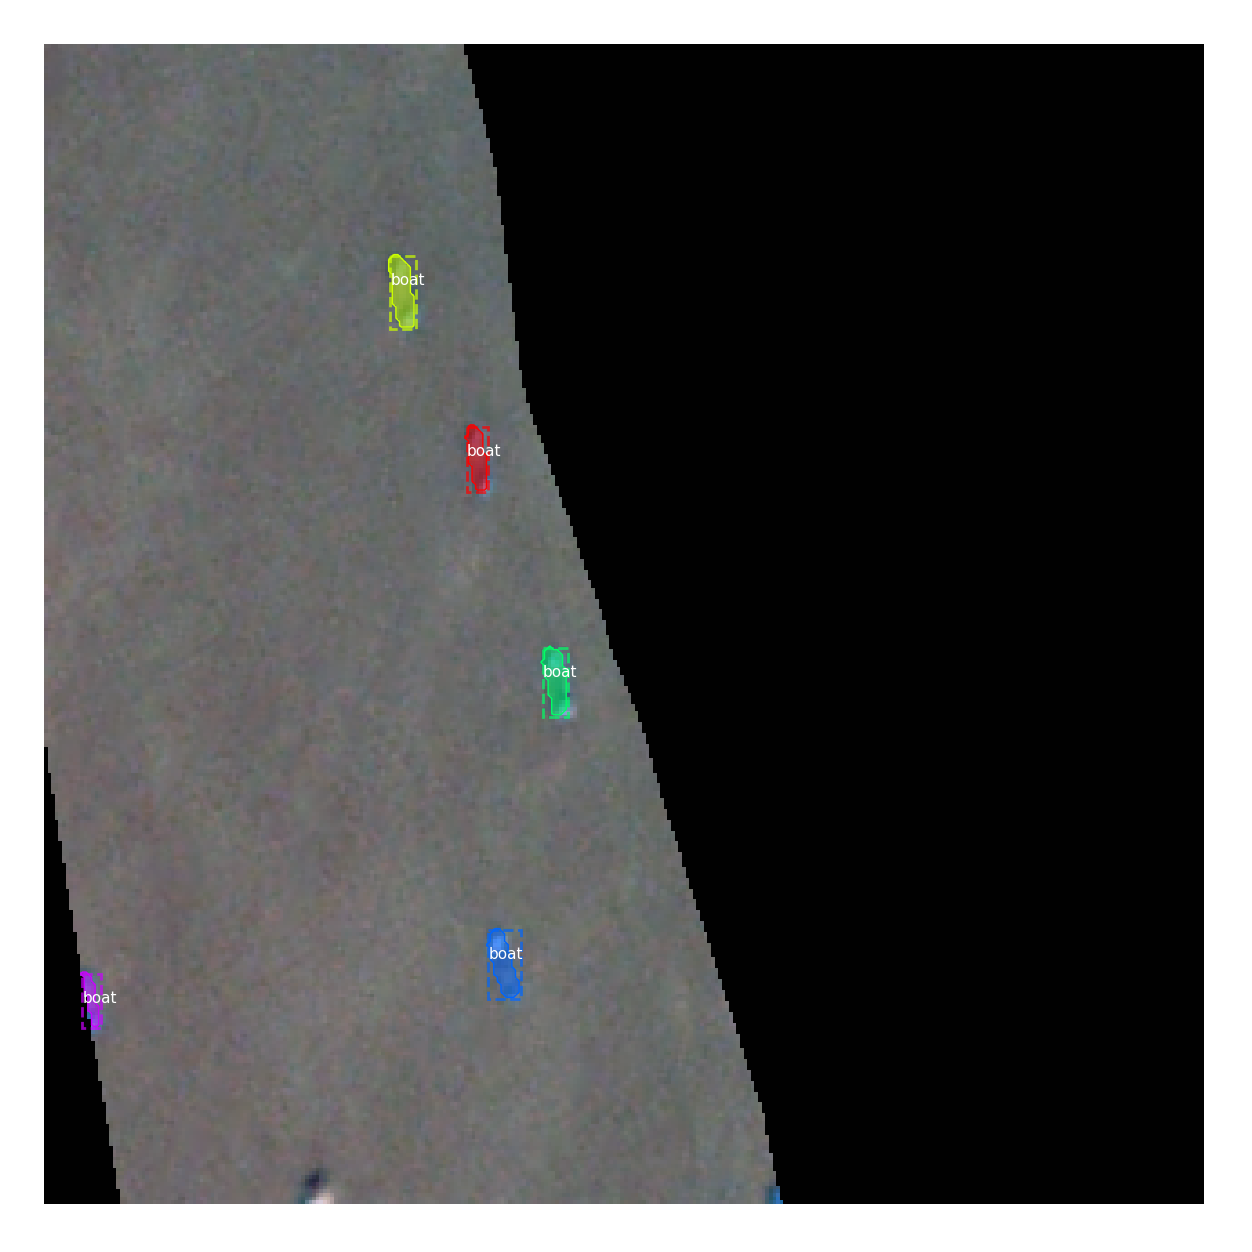

In [22]:
# Load random image and ground truth mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image ID: Mekong.Mekong_2021.08.28_101f_merge_03_08_RGB.png (191) E:/Anaconda/Mask_RCNN/Annotationdata_alt/train\Mekong_2021.08.28_101f_merge_03_08_RGB.png
Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   16.00000  max:  261.00000  int32
gt_mask                  shape: (320, 320, 2)         min:    0.00000  max:    1.00000  uint8




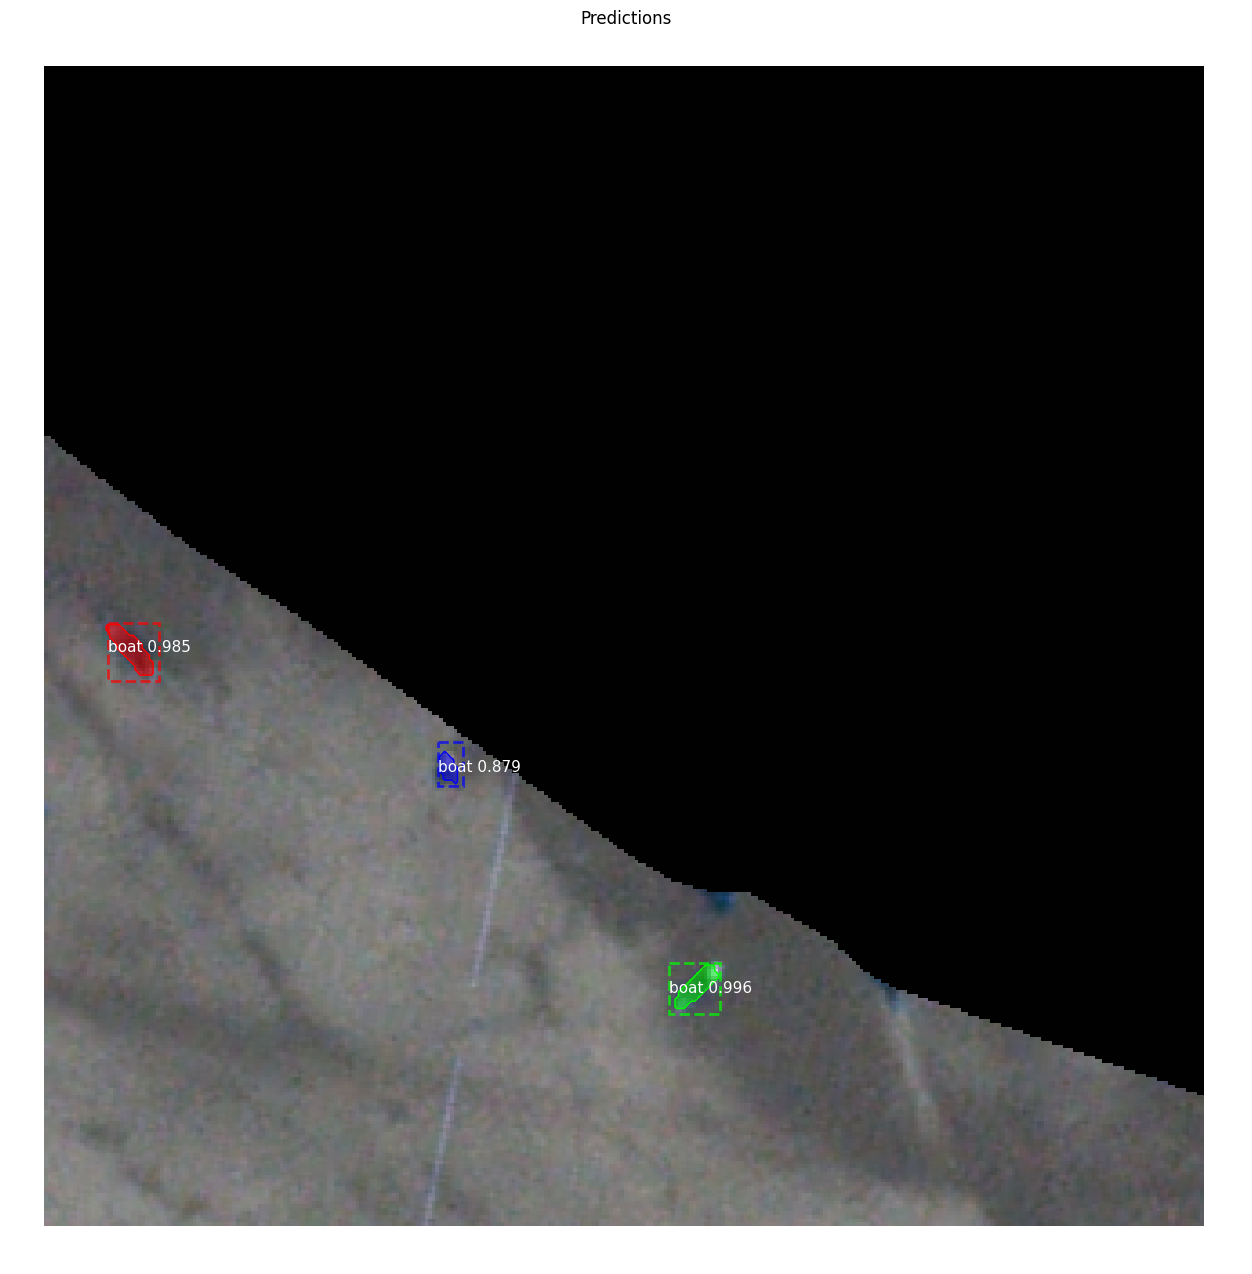

In [23]:
image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print("\n")

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


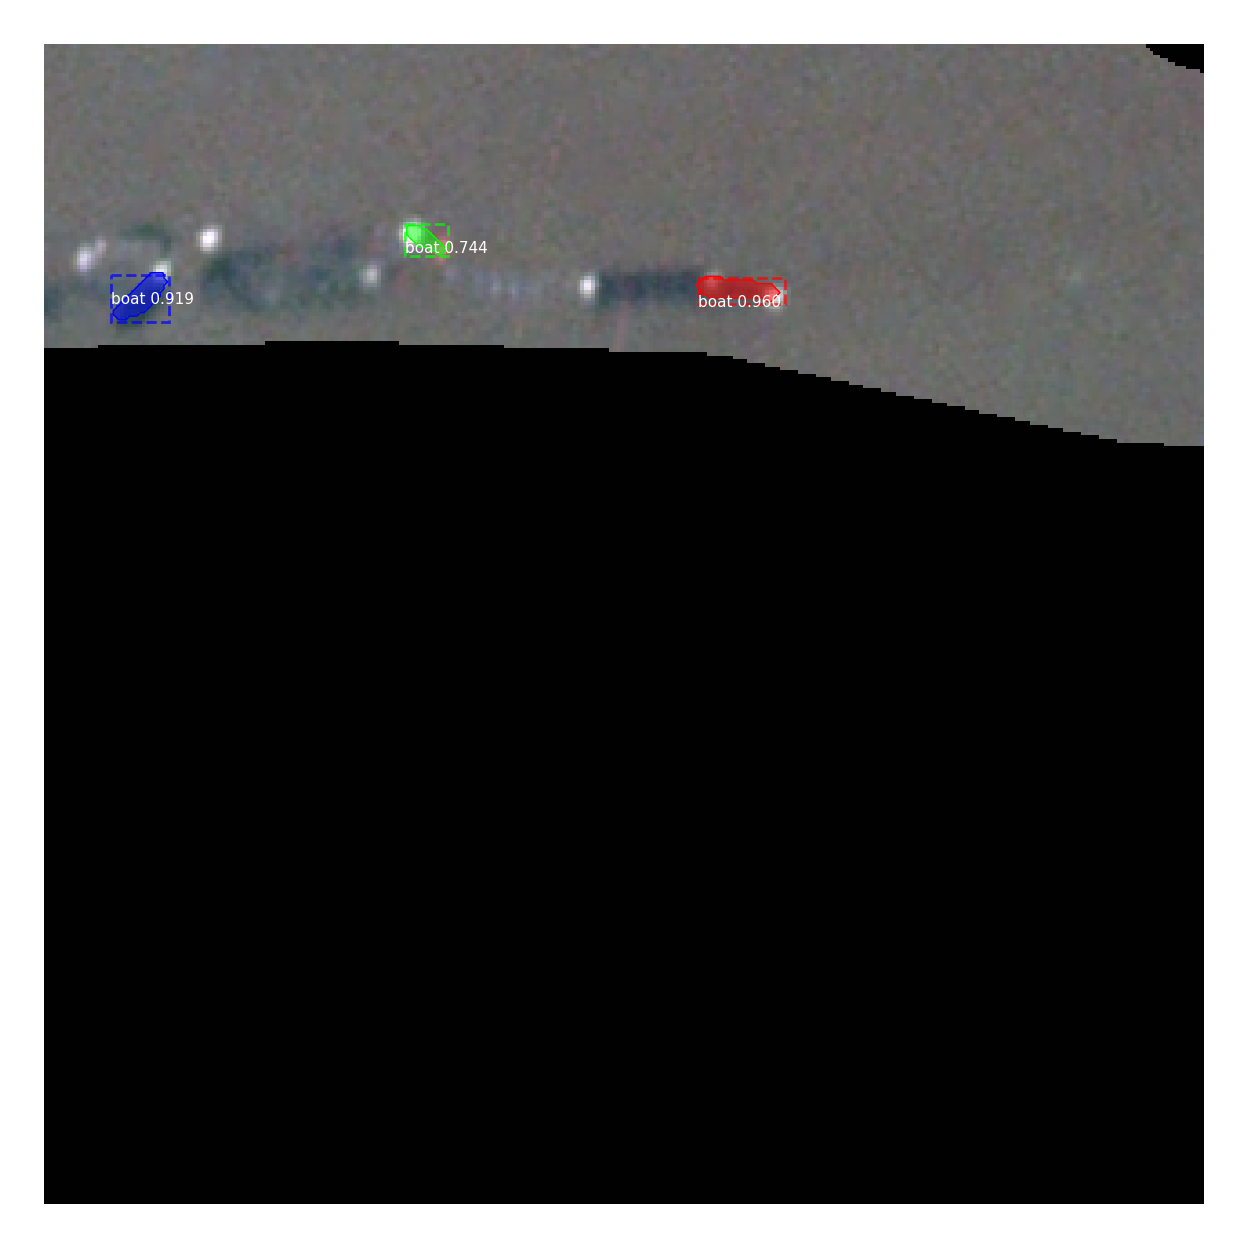

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  231.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  110.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


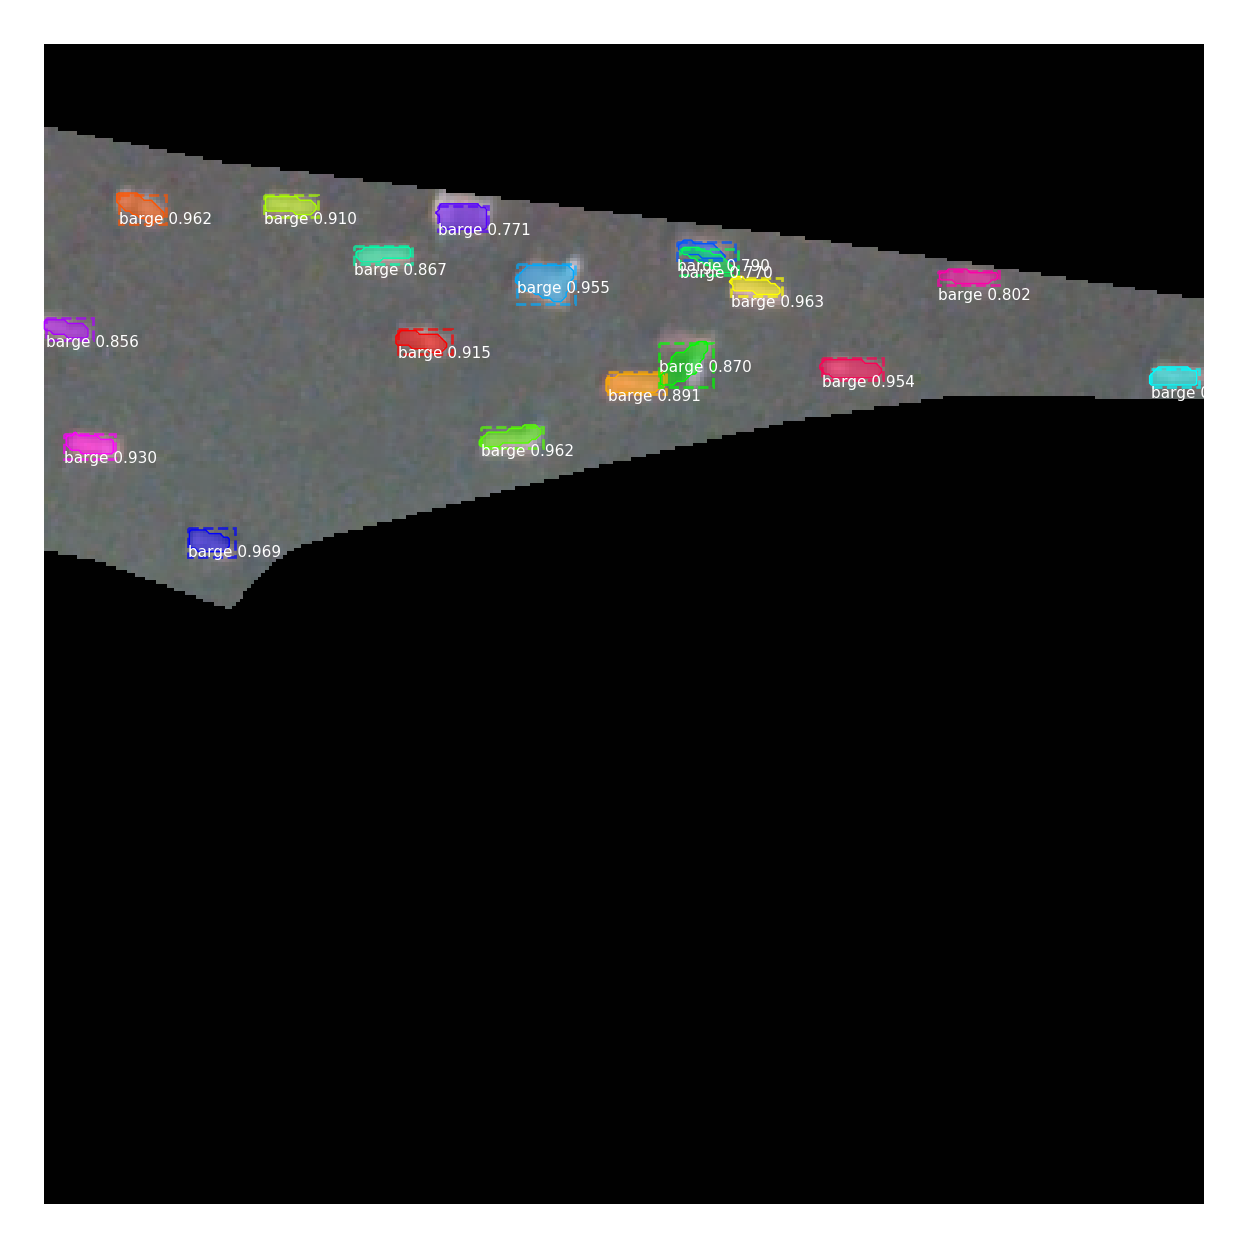

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  245.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  141.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


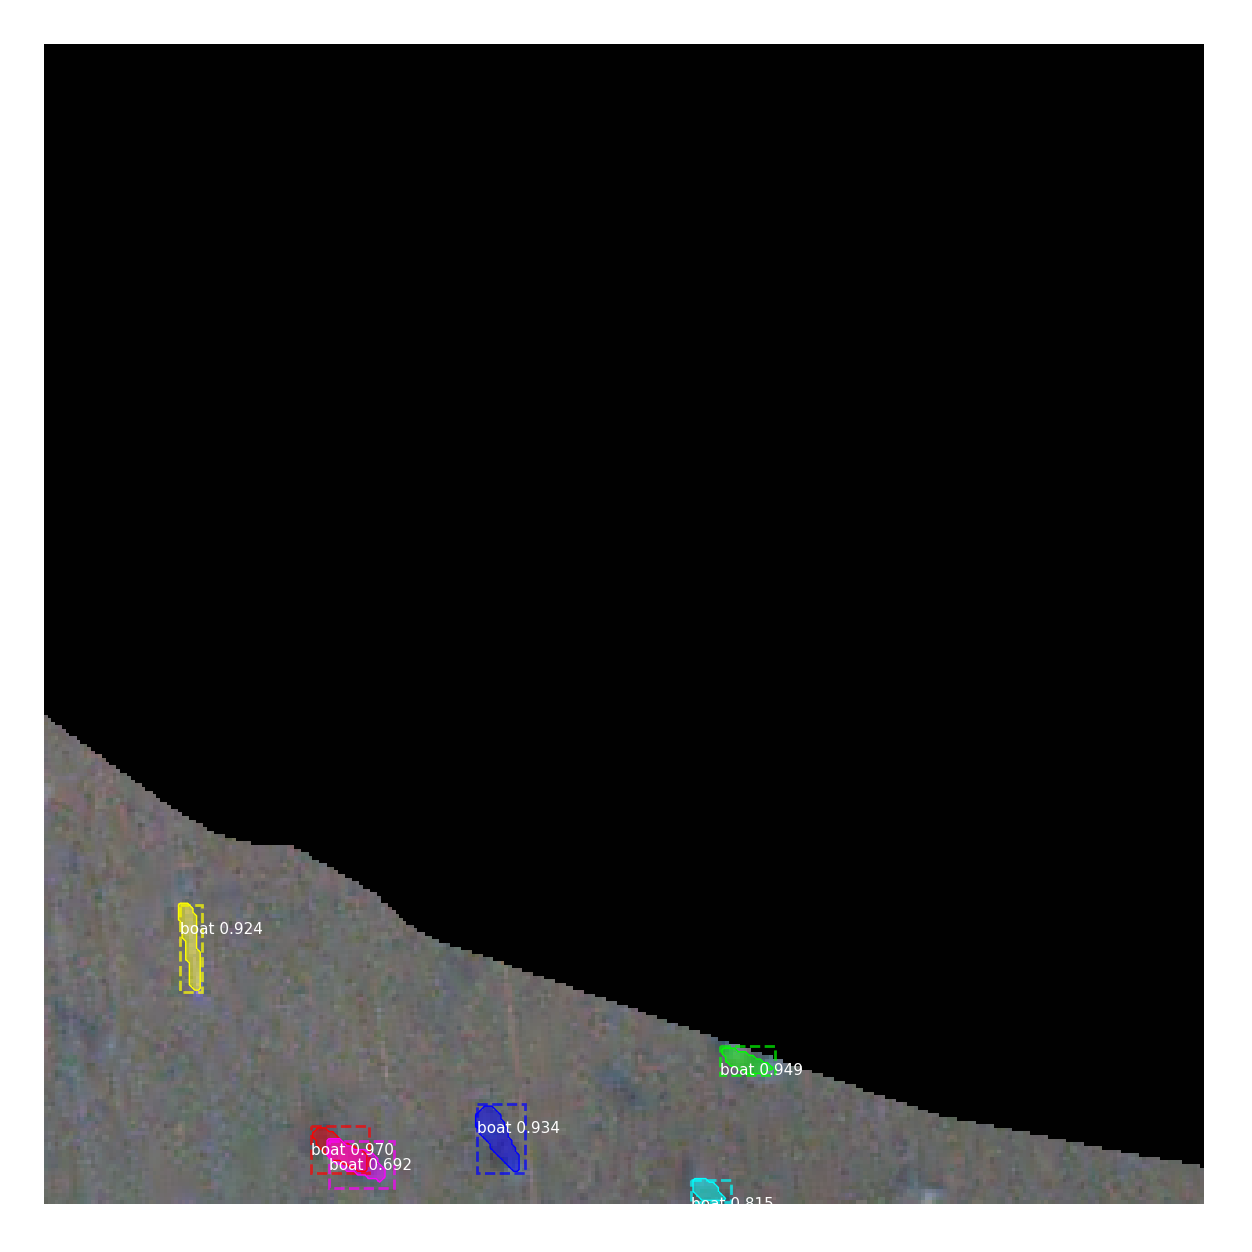

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  178.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   65.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


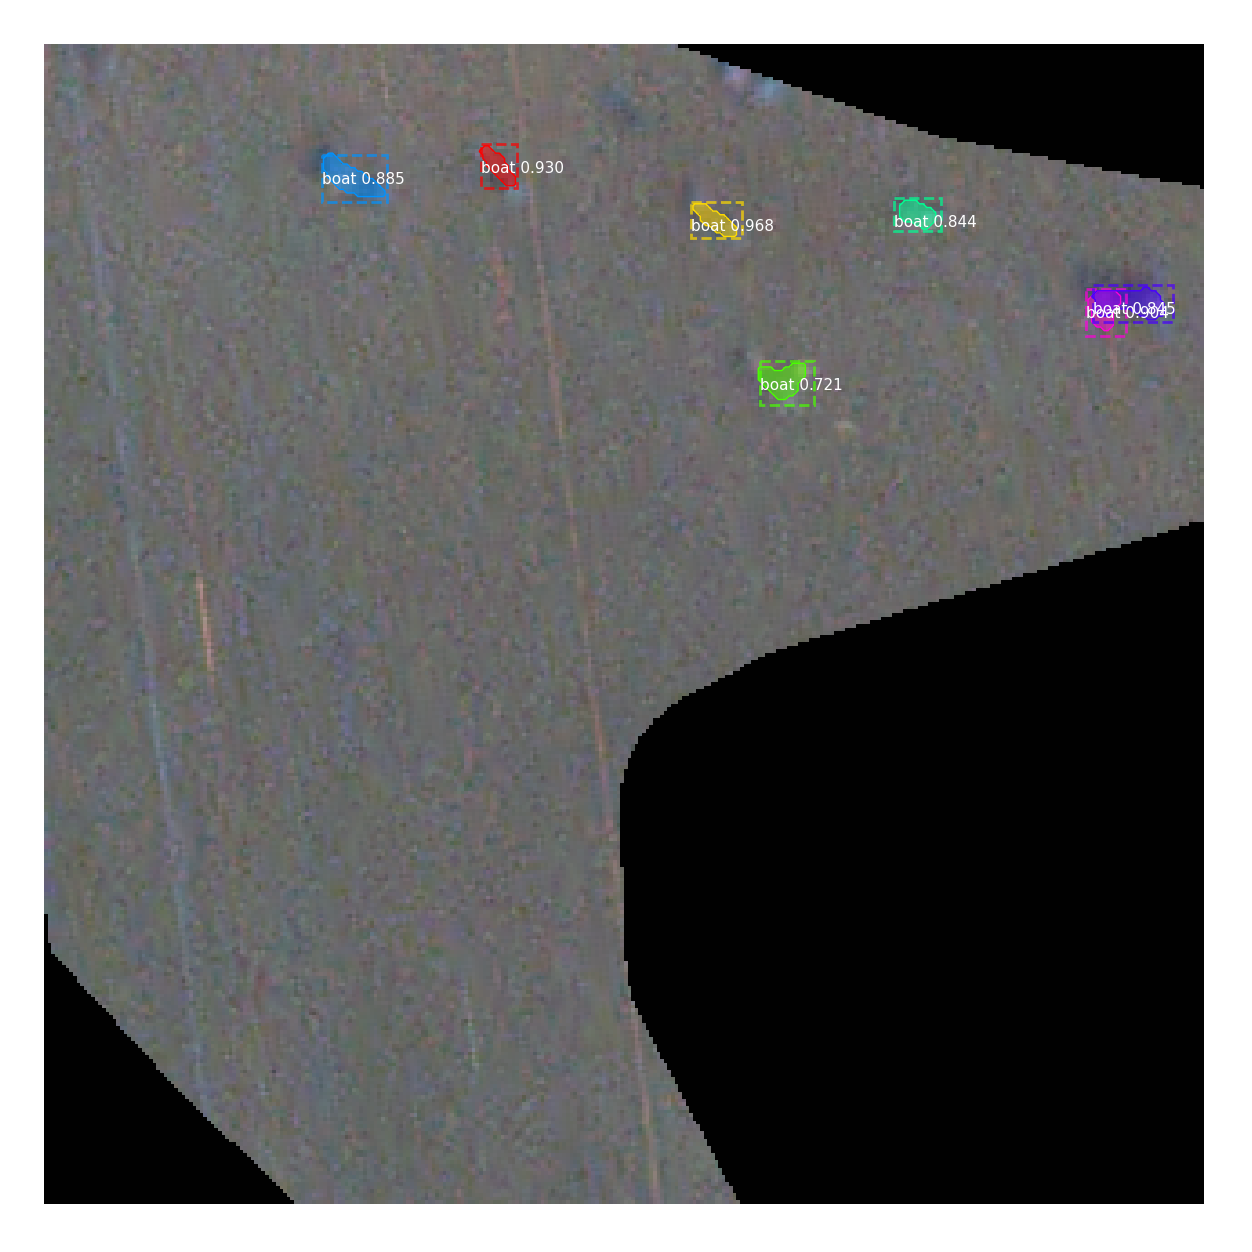

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  177.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   59.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


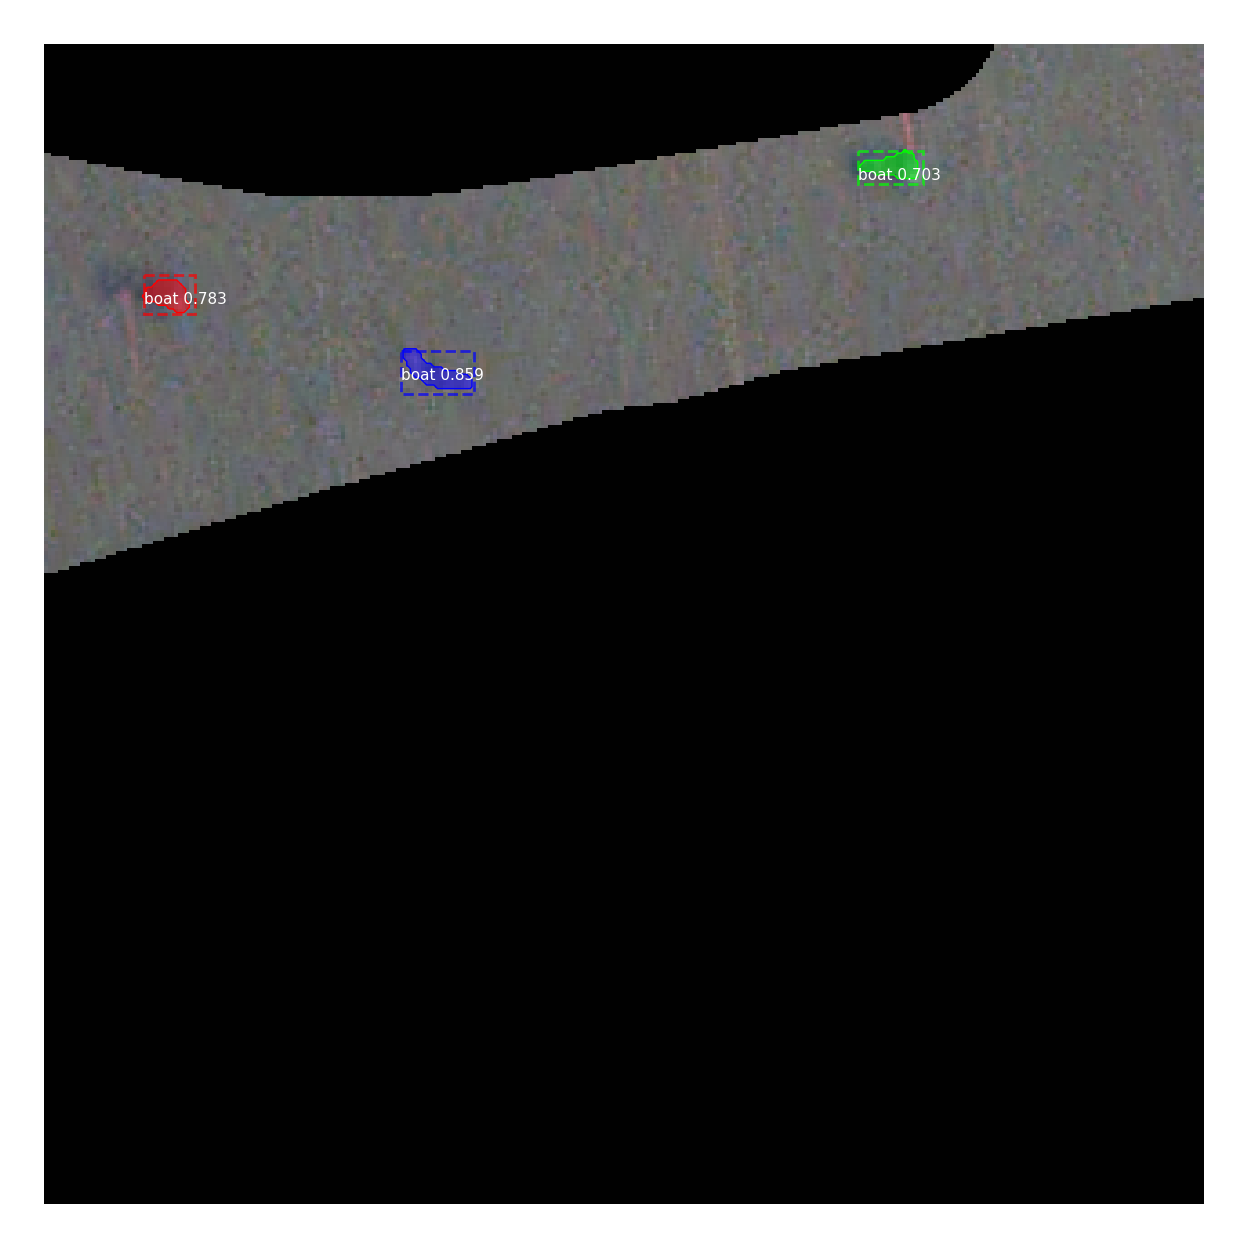

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  170.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   66.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


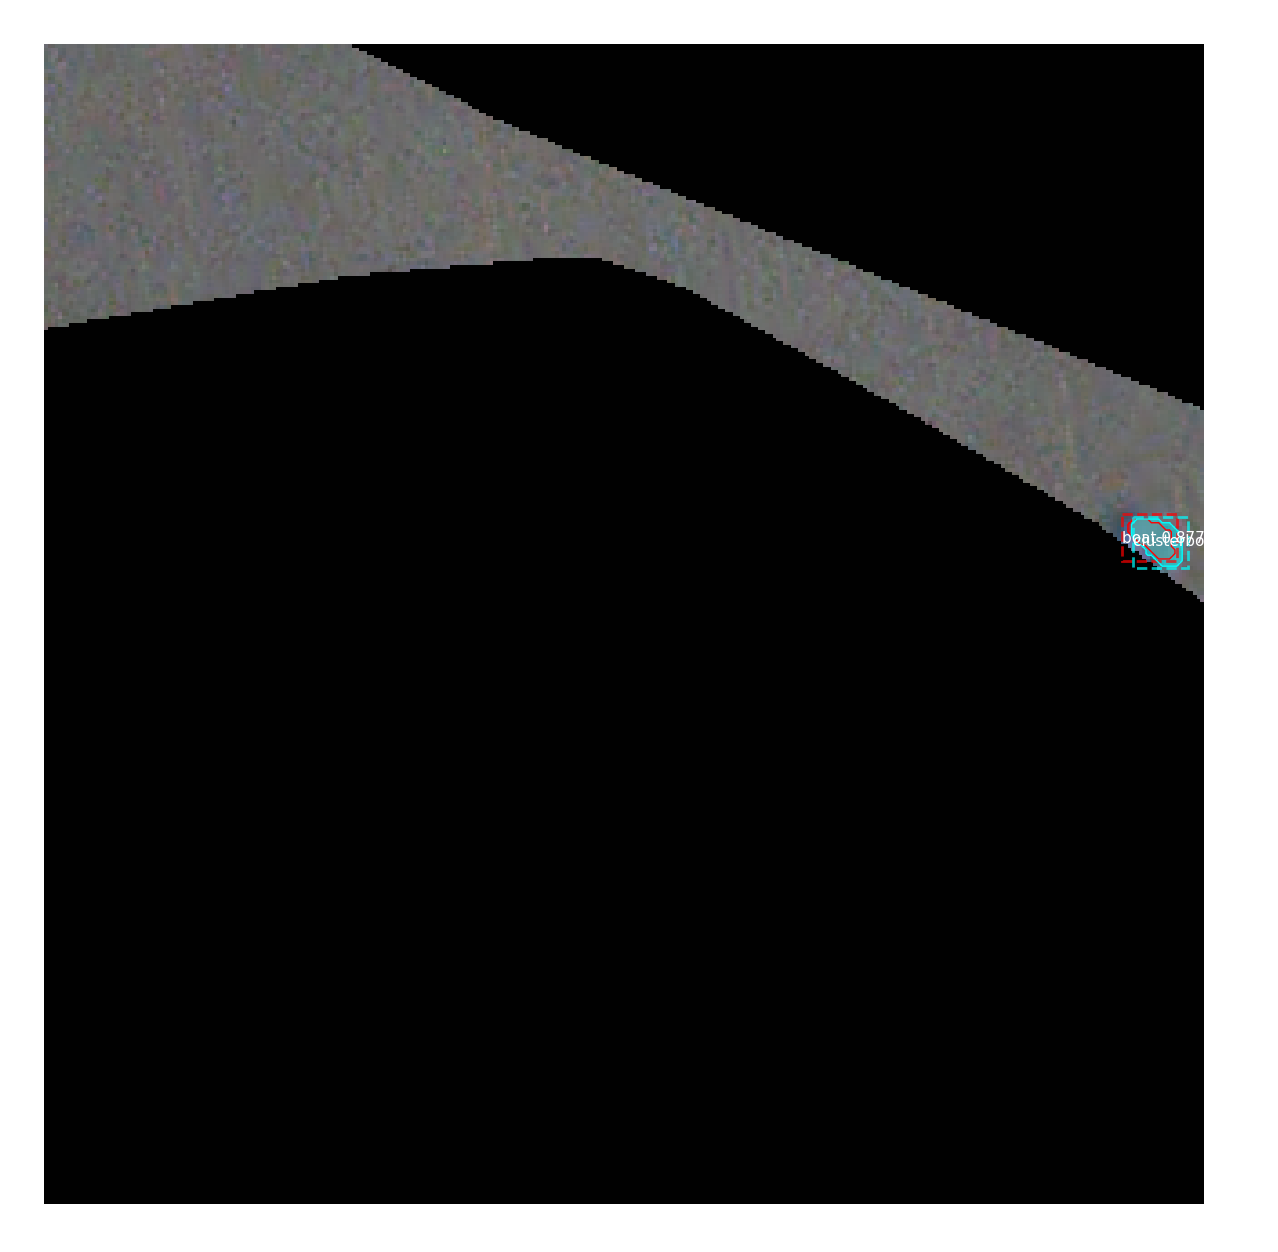

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  205.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   81.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


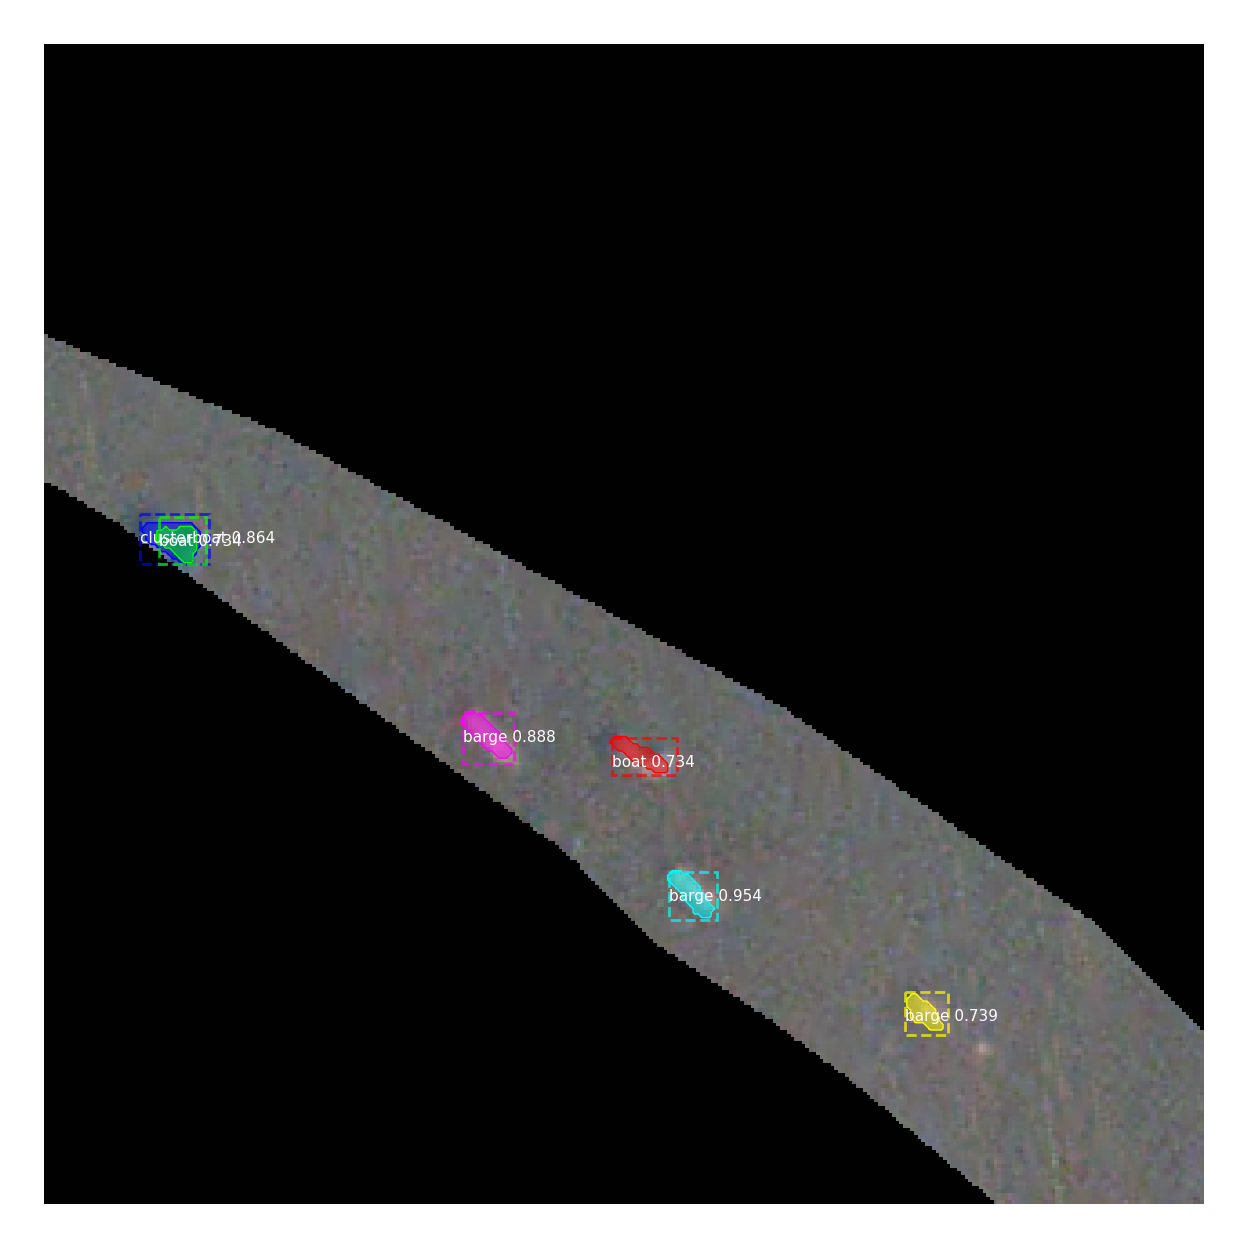

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  208.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   90.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


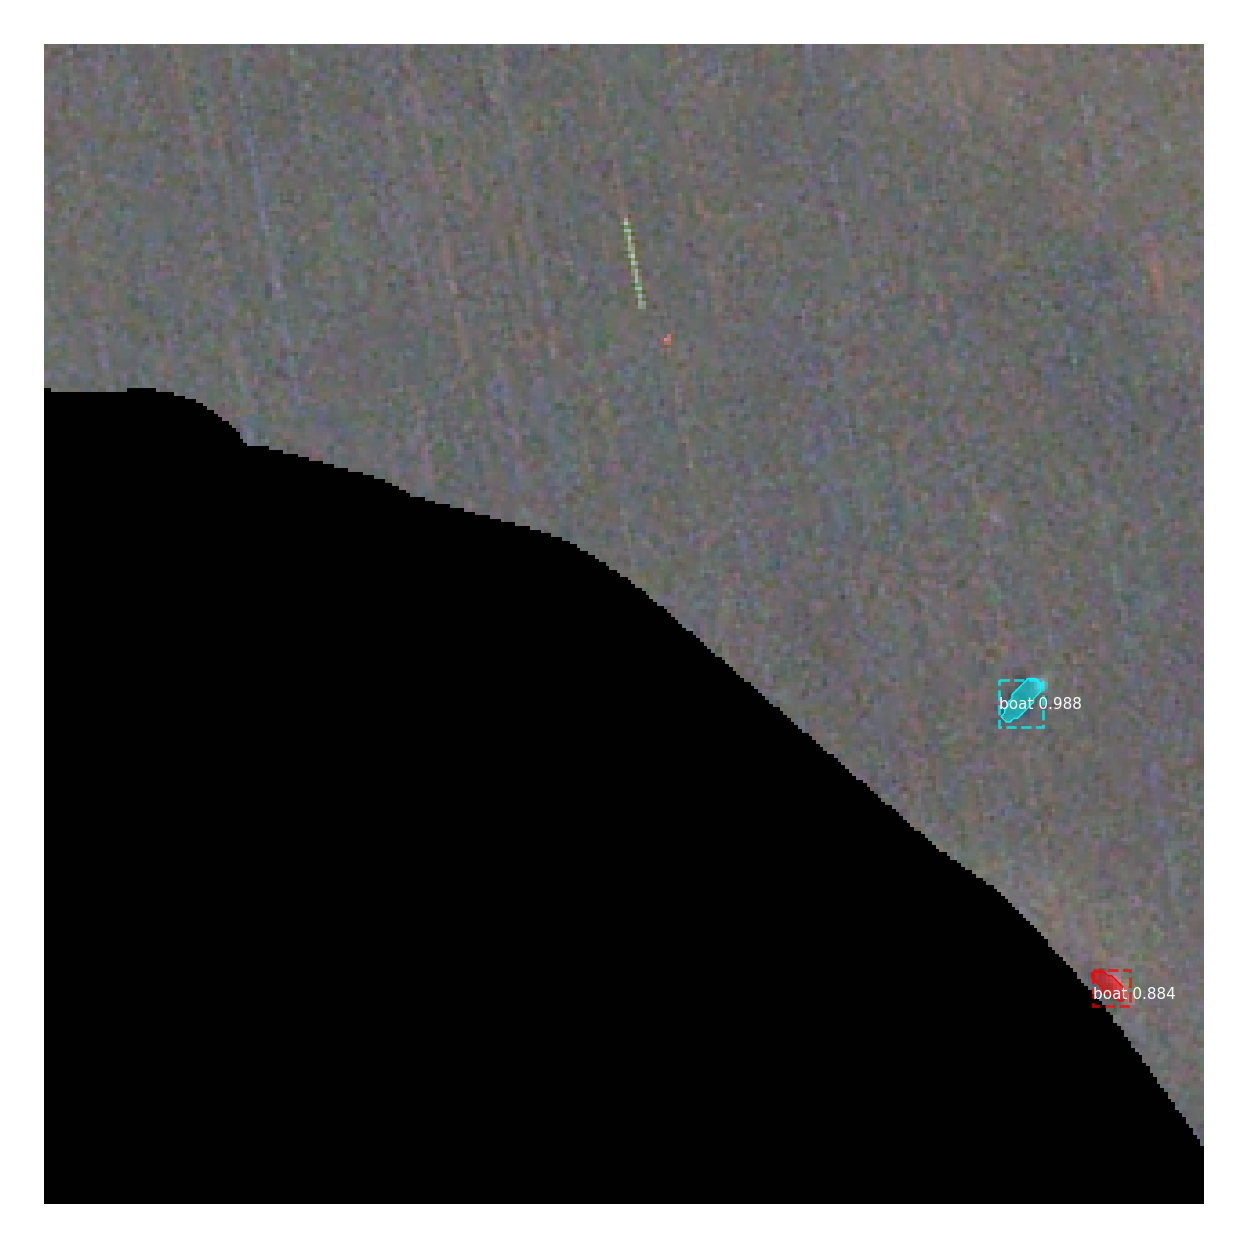

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  248.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  141.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


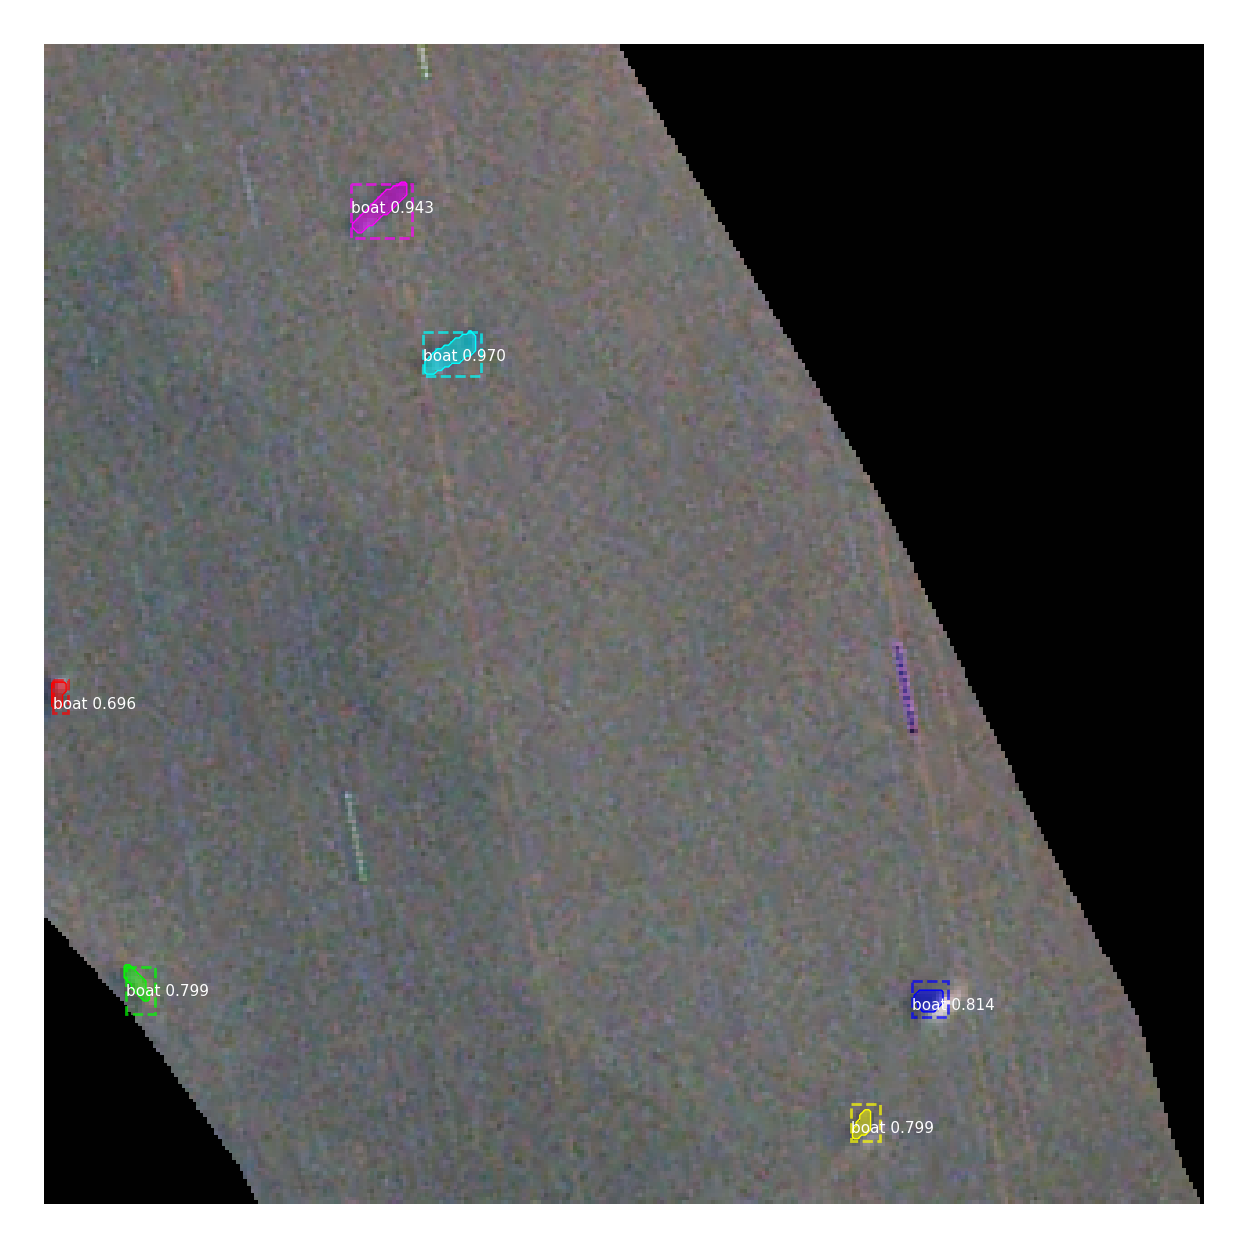

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  181.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   77.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


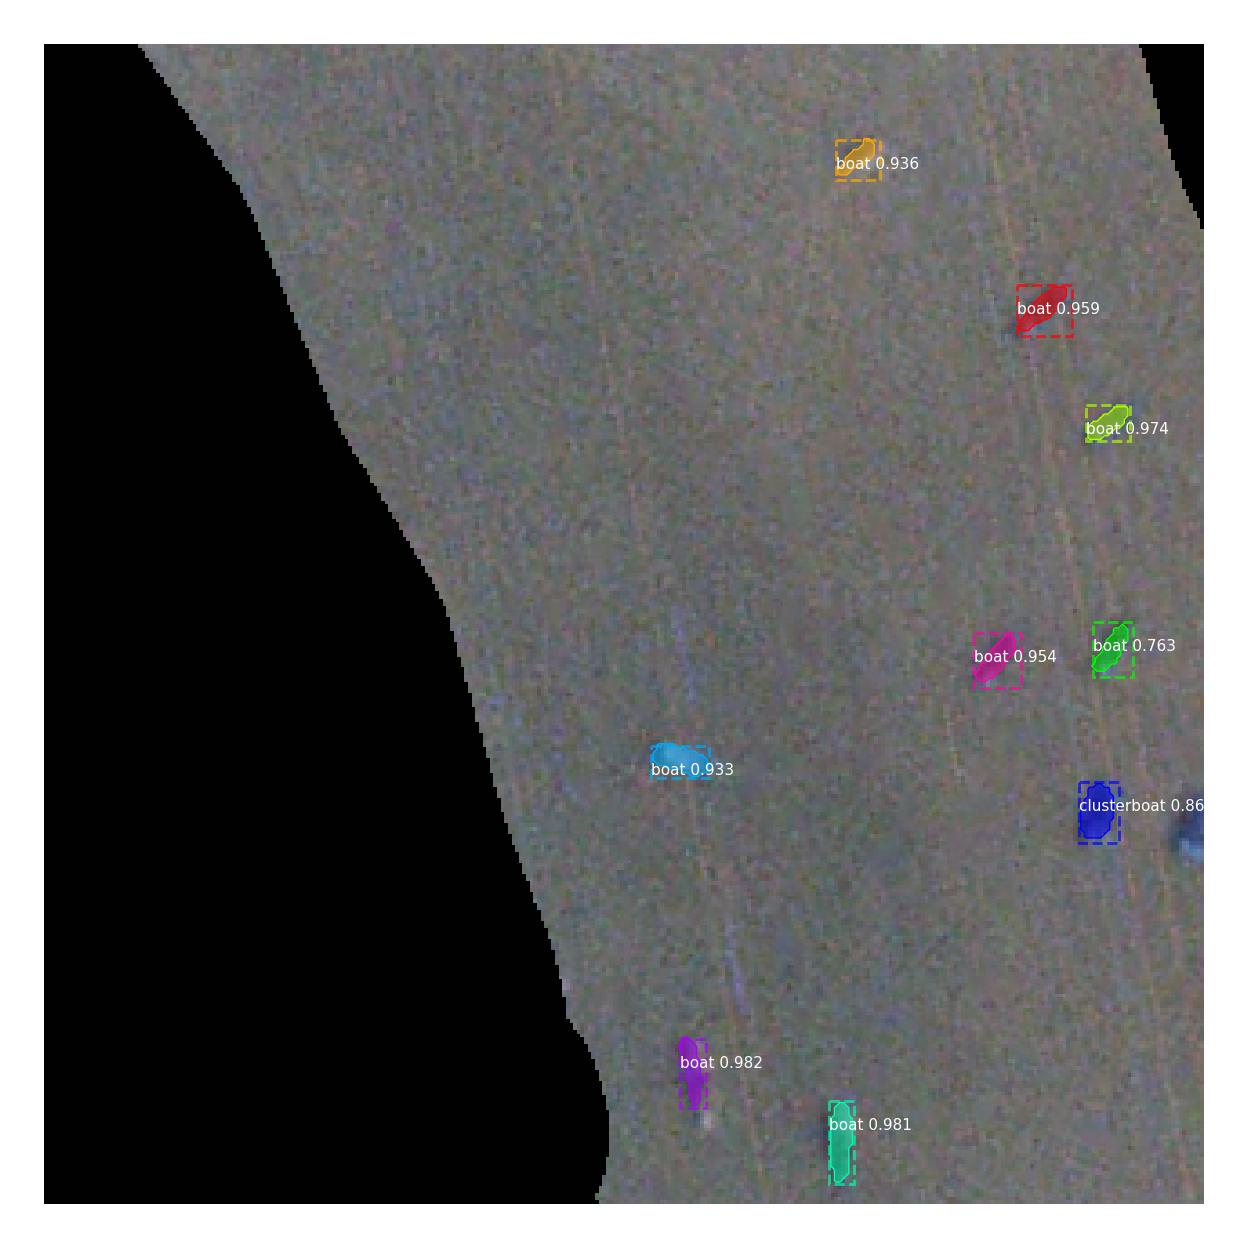

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  230.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  126.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


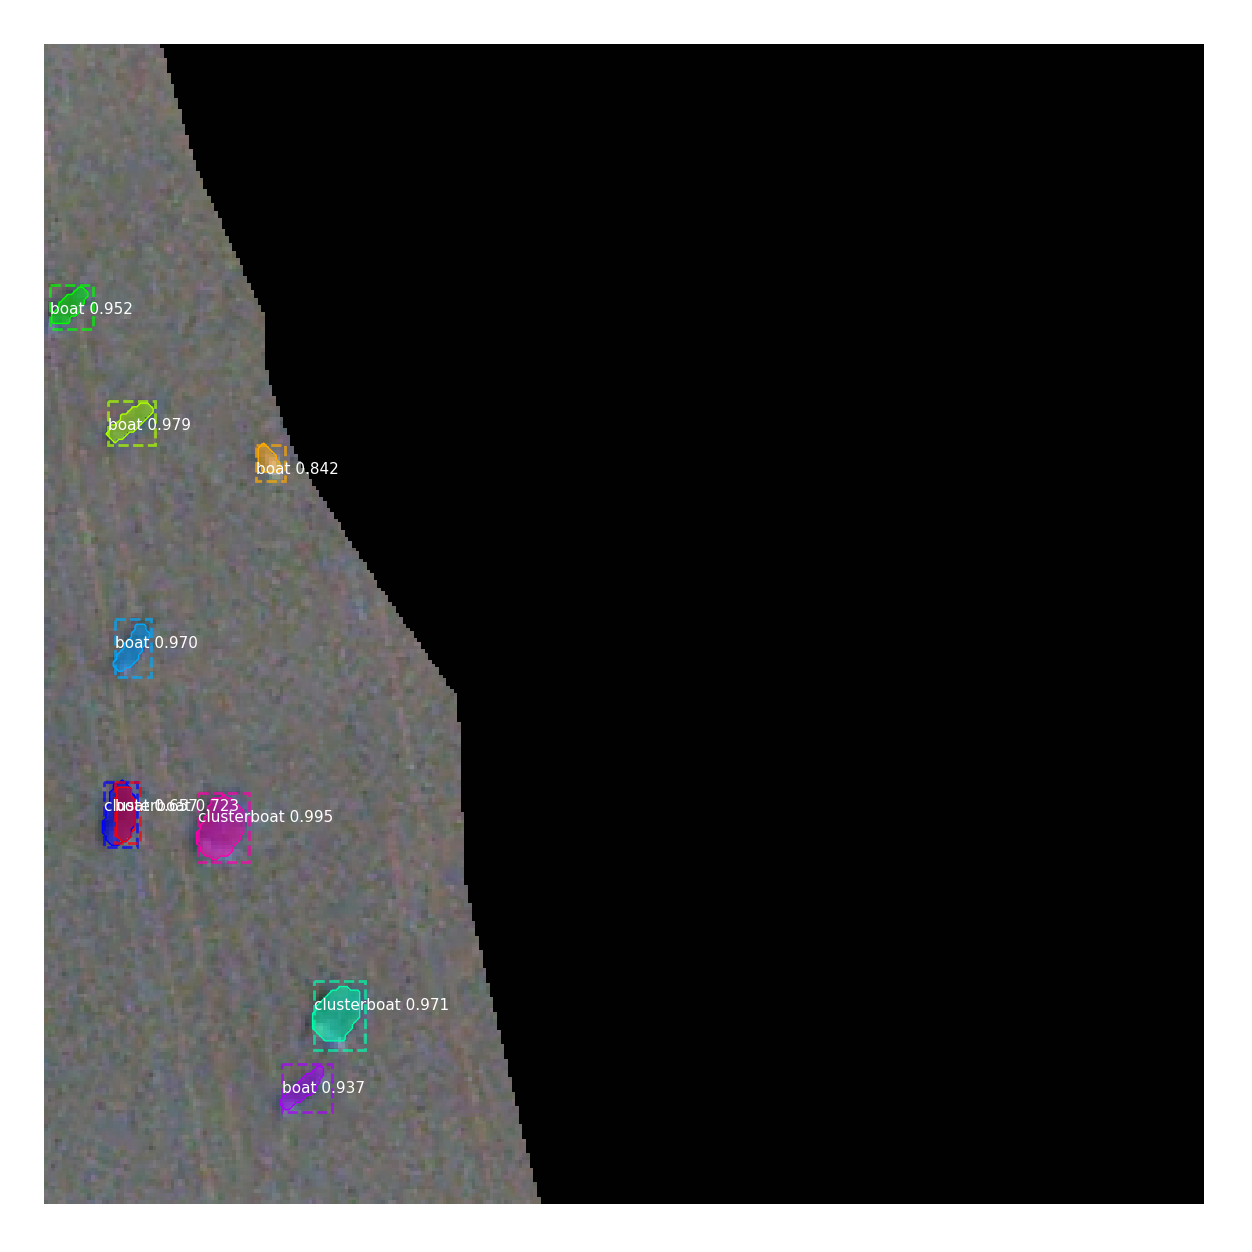

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


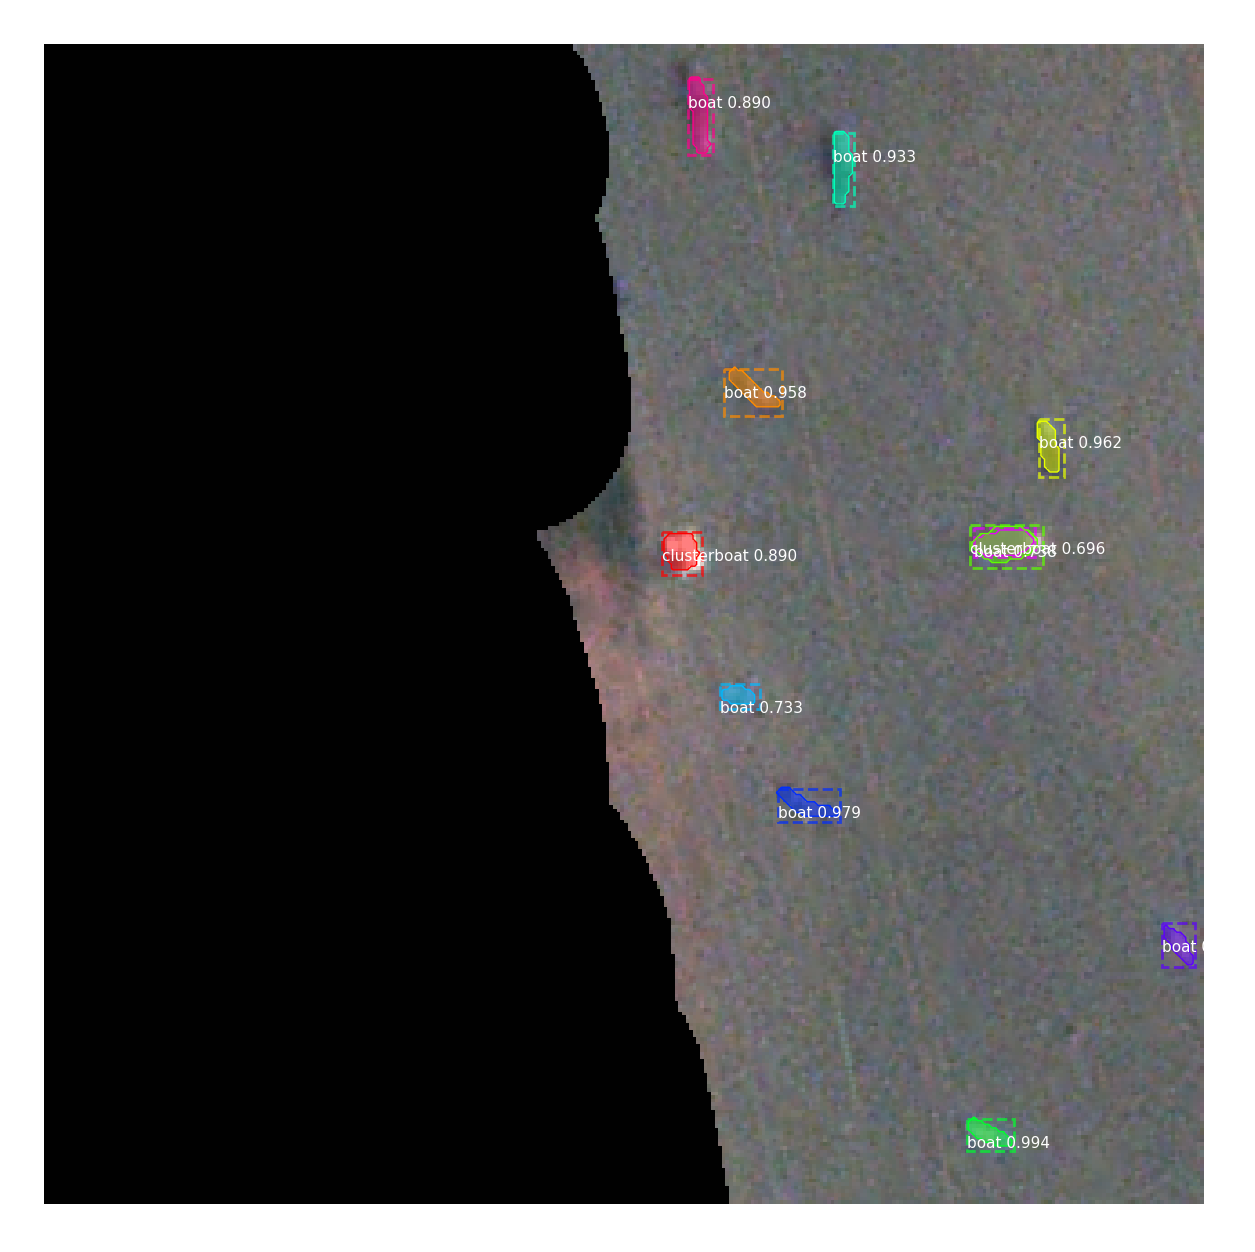

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  242.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  118.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


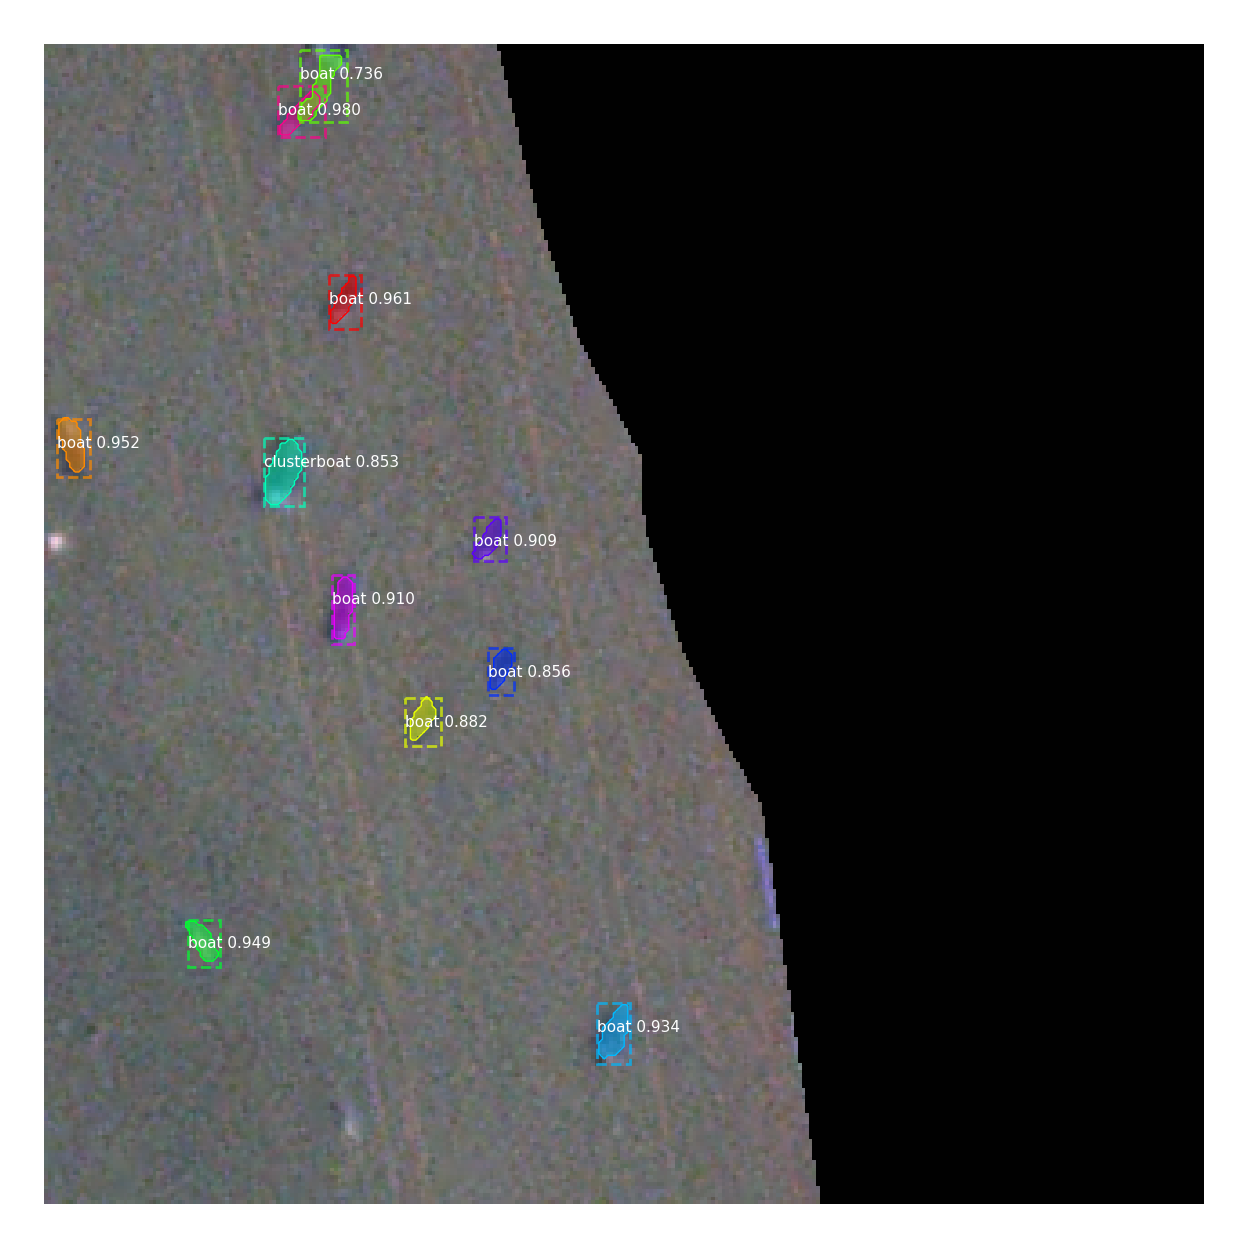

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  222.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  118.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


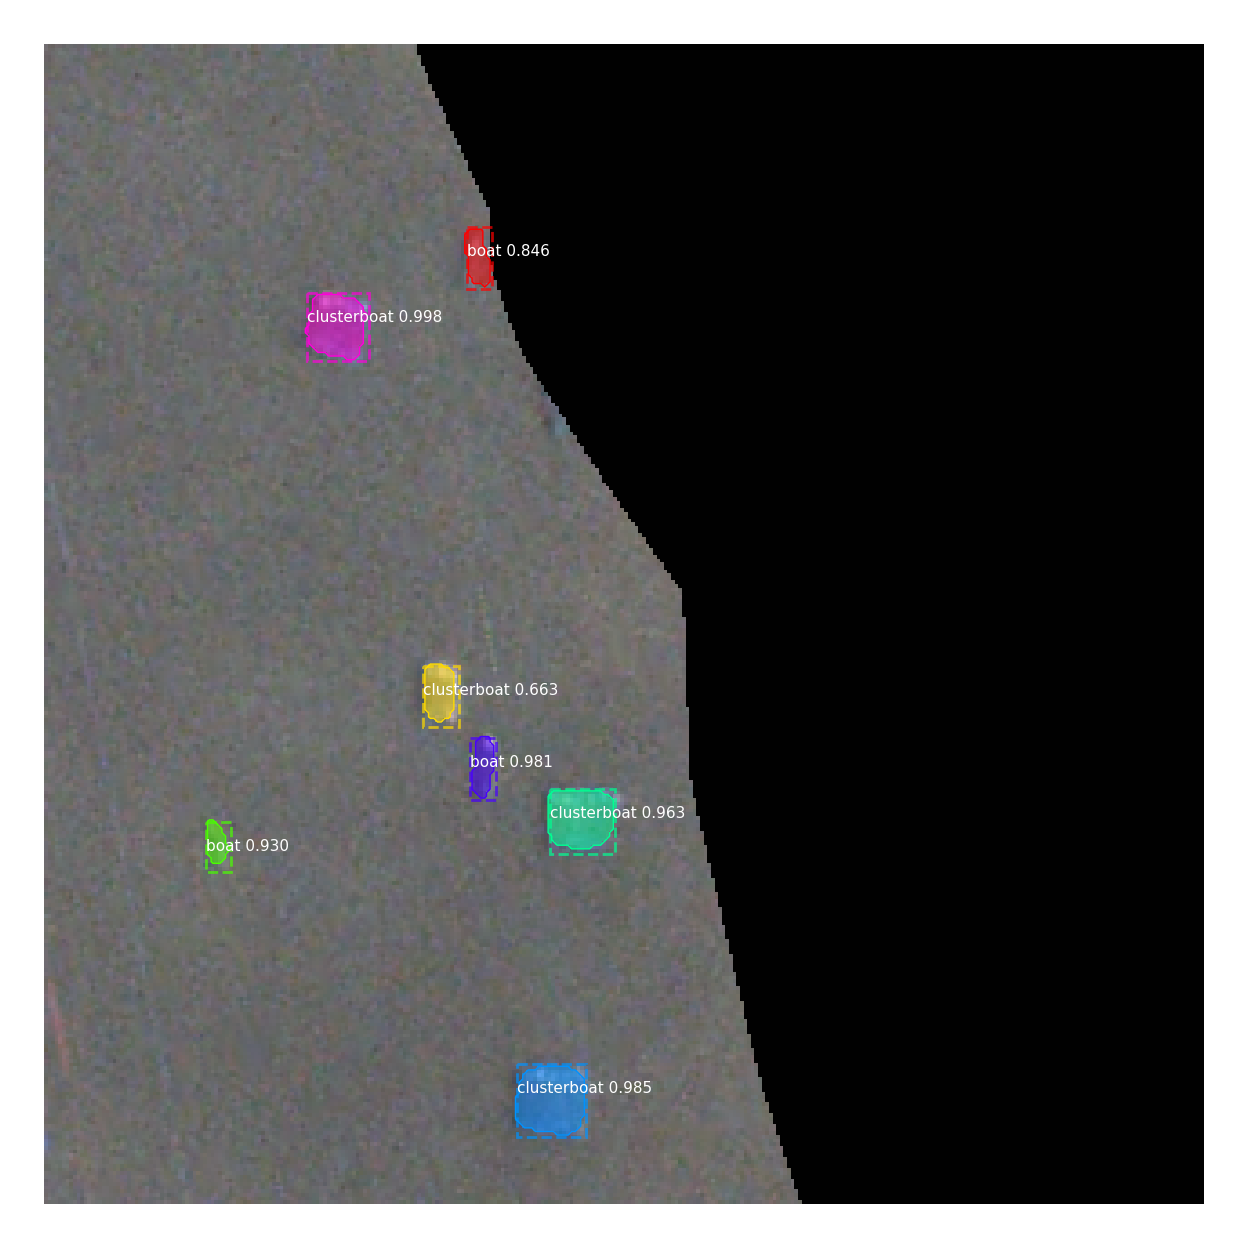

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


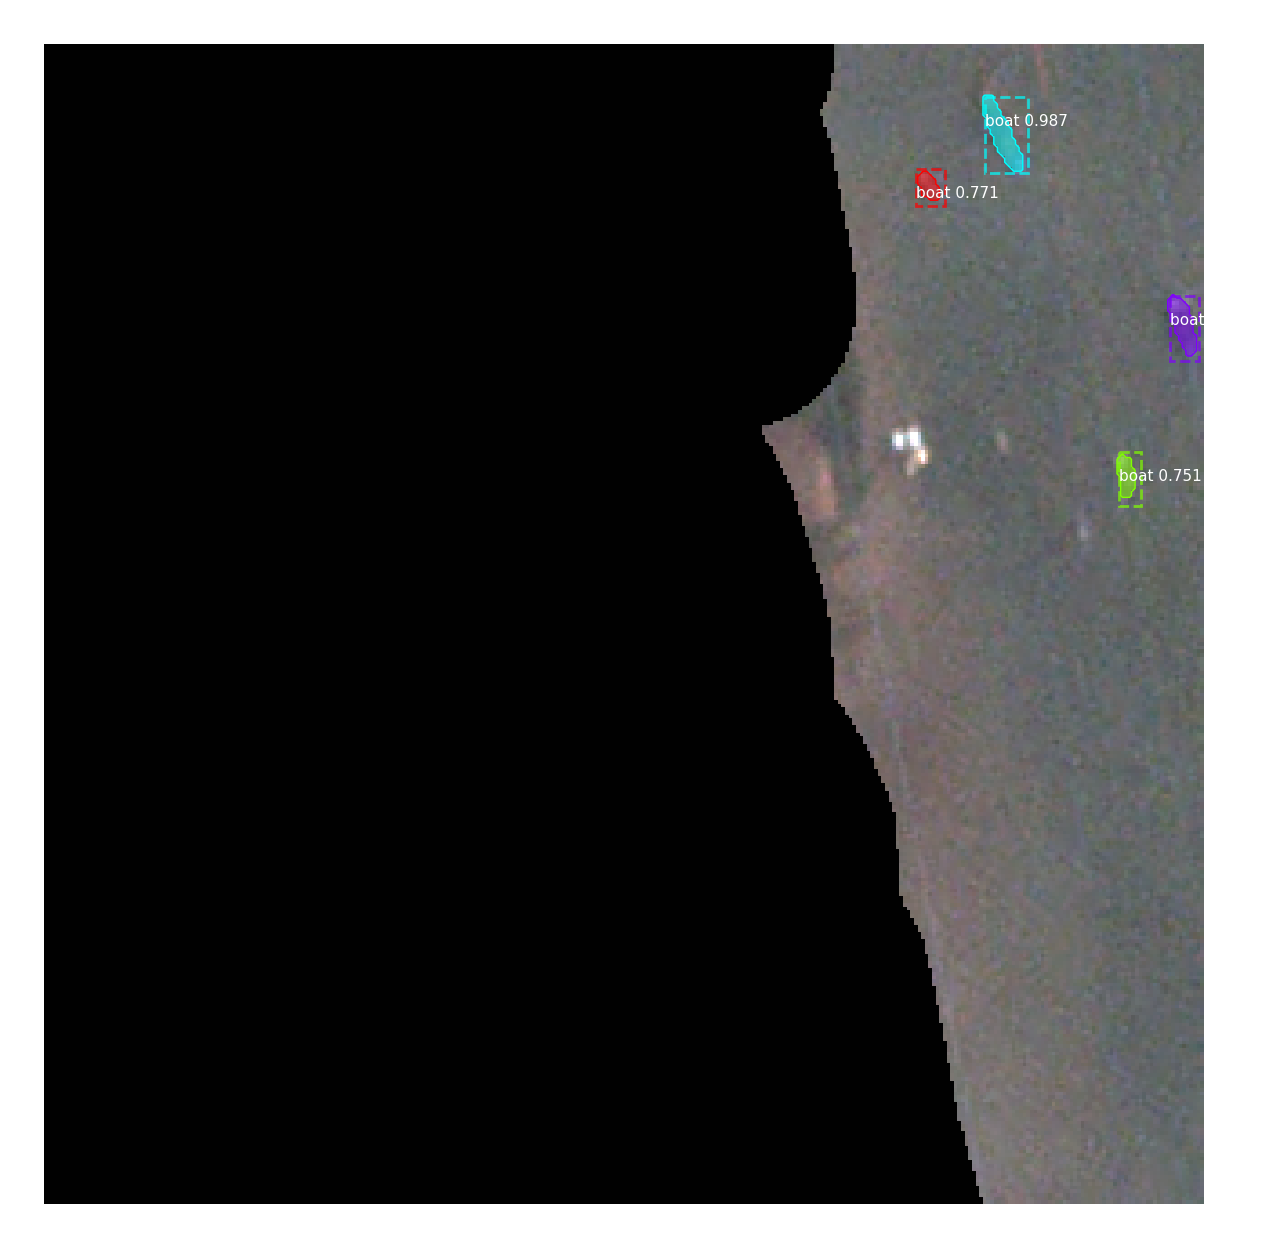

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  229.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  125.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


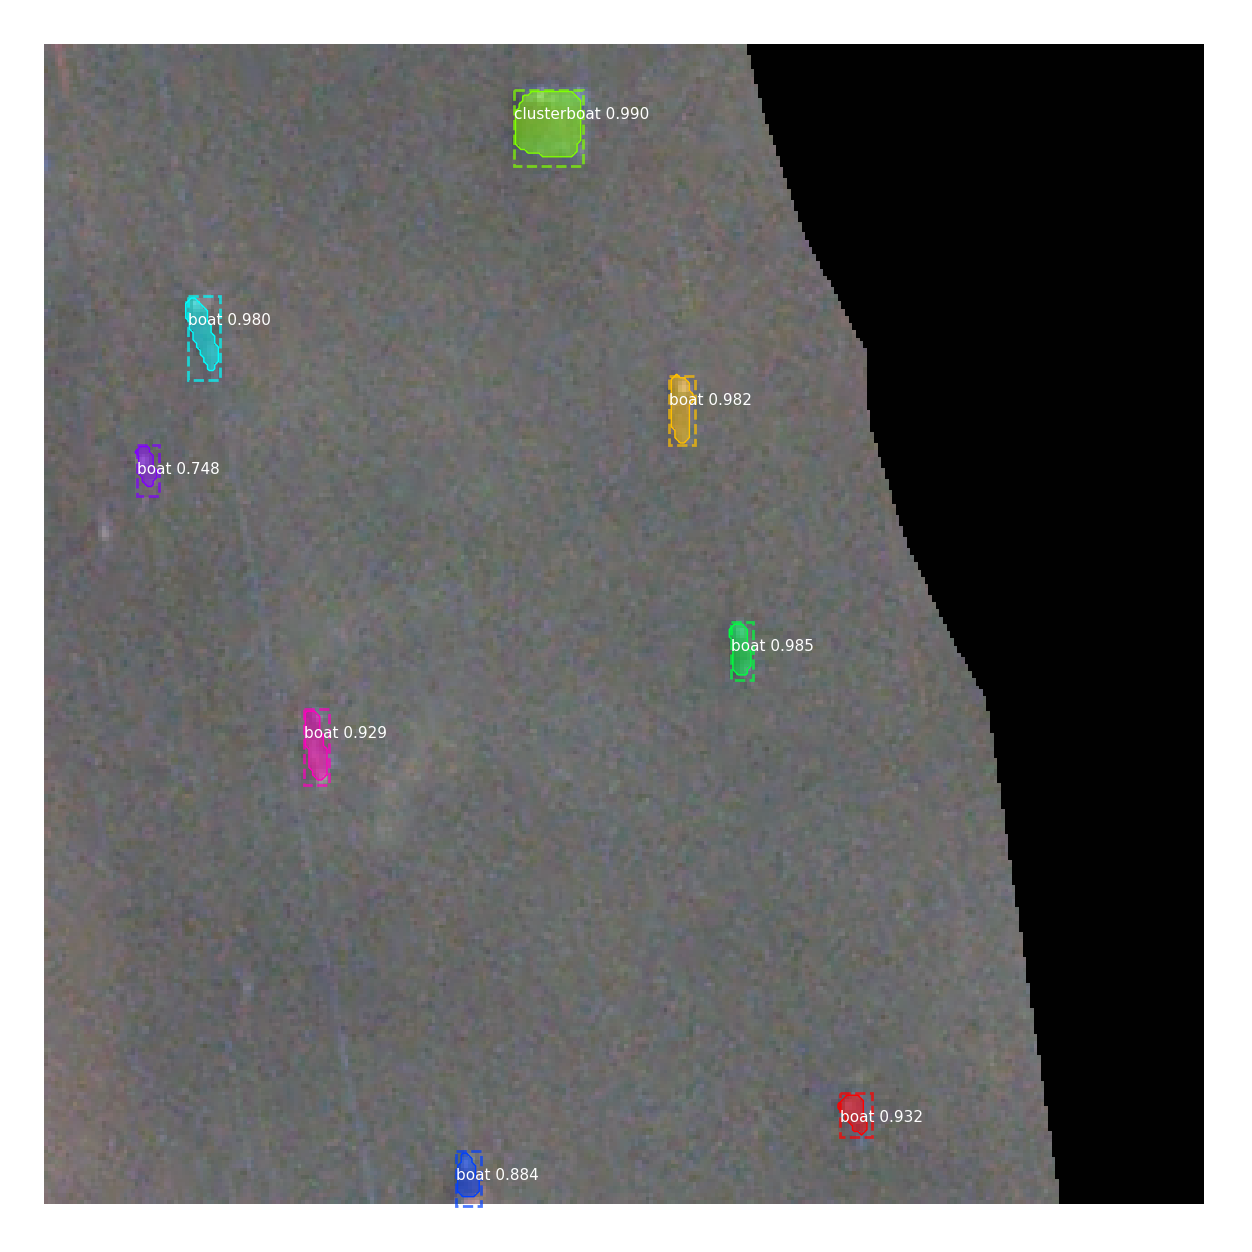

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


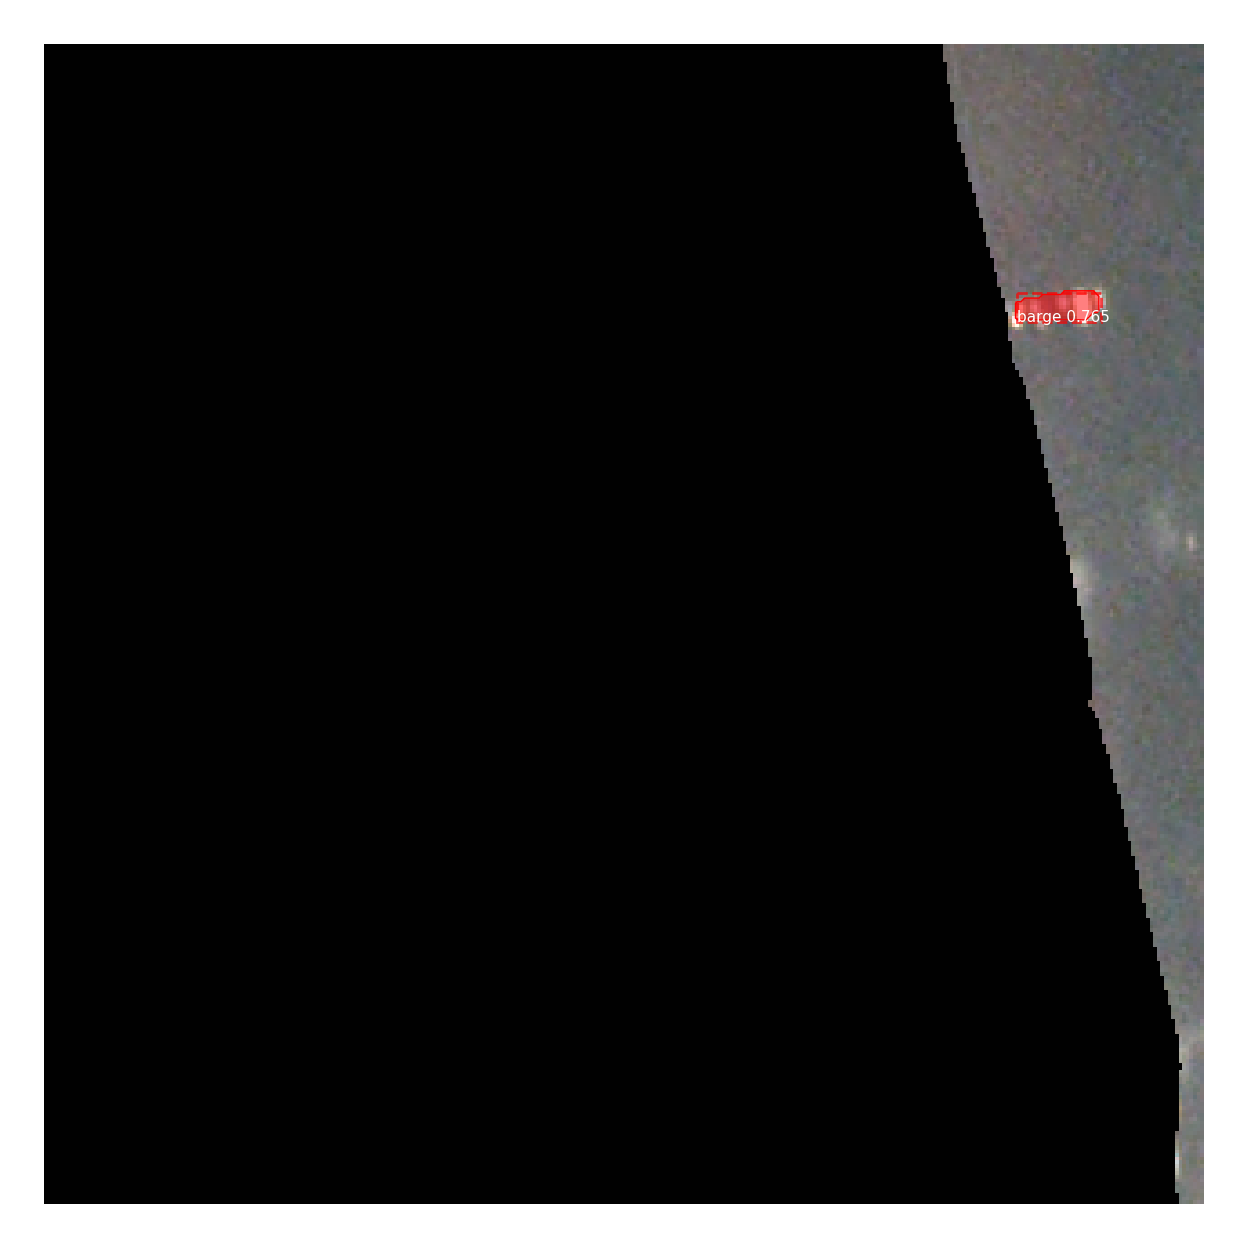

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


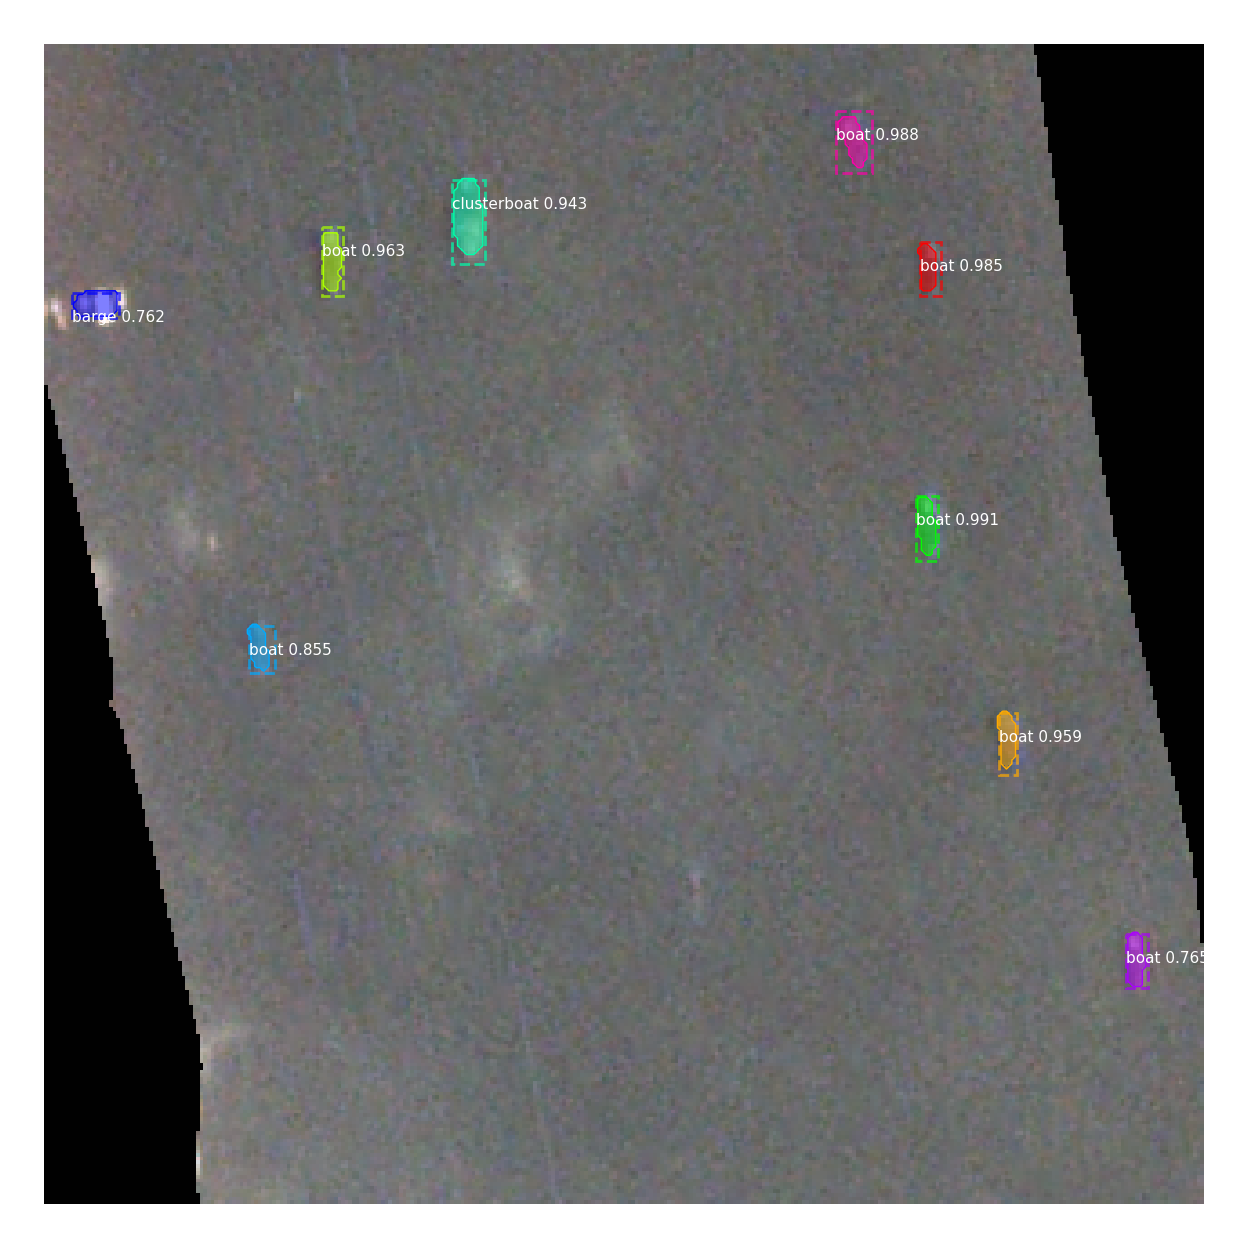

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


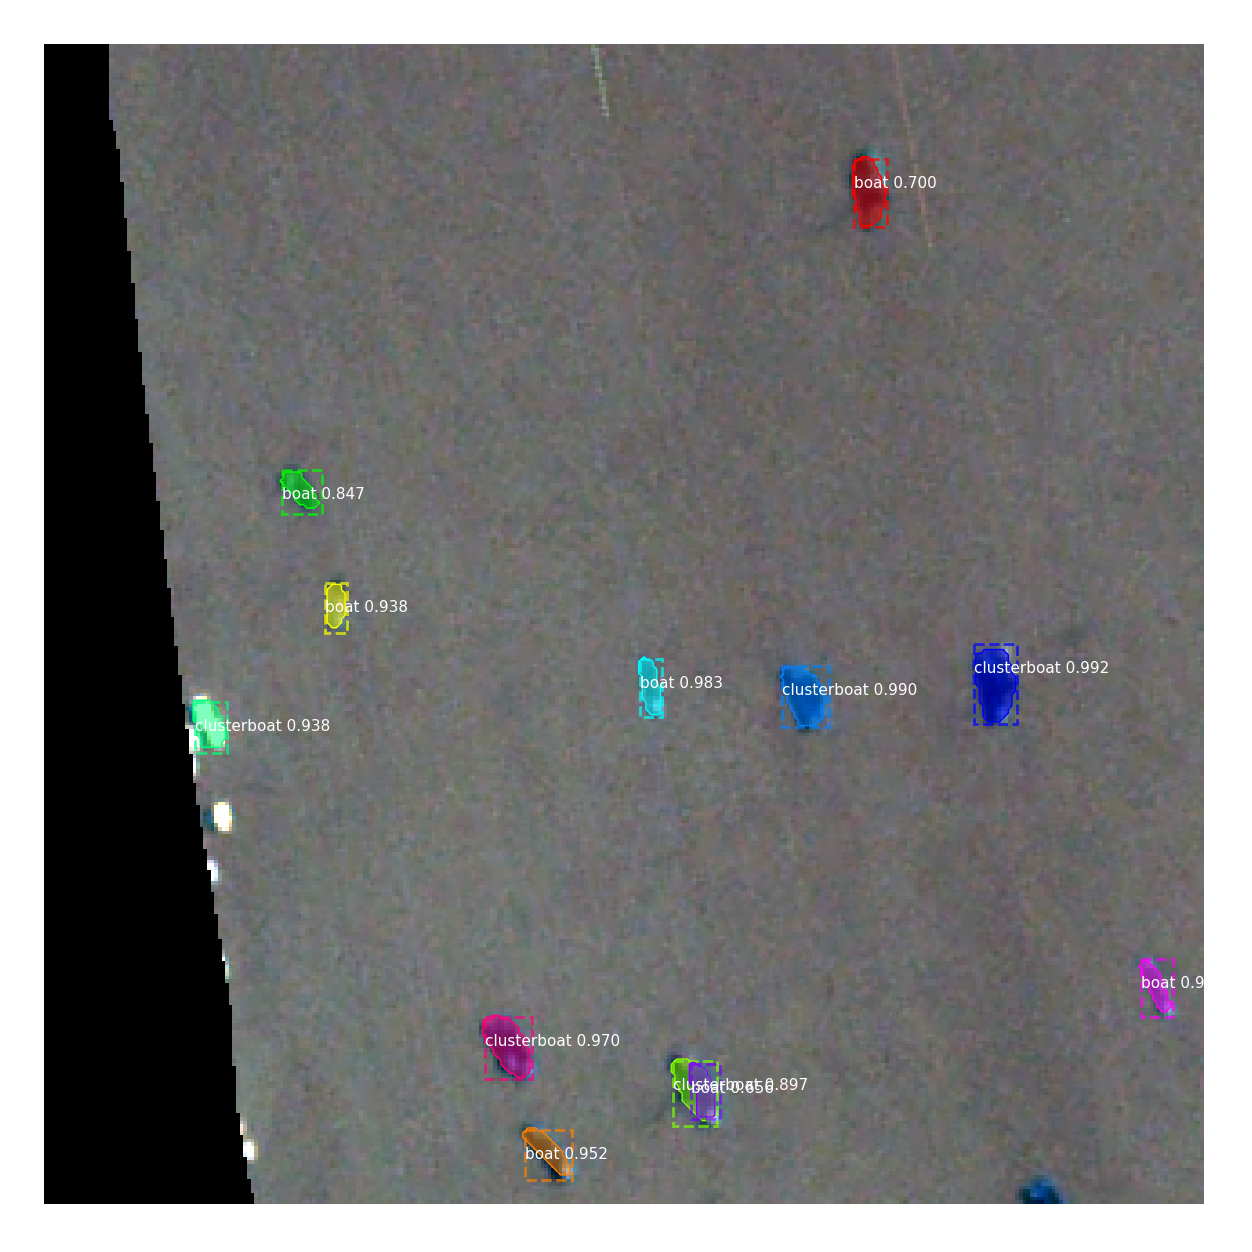

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


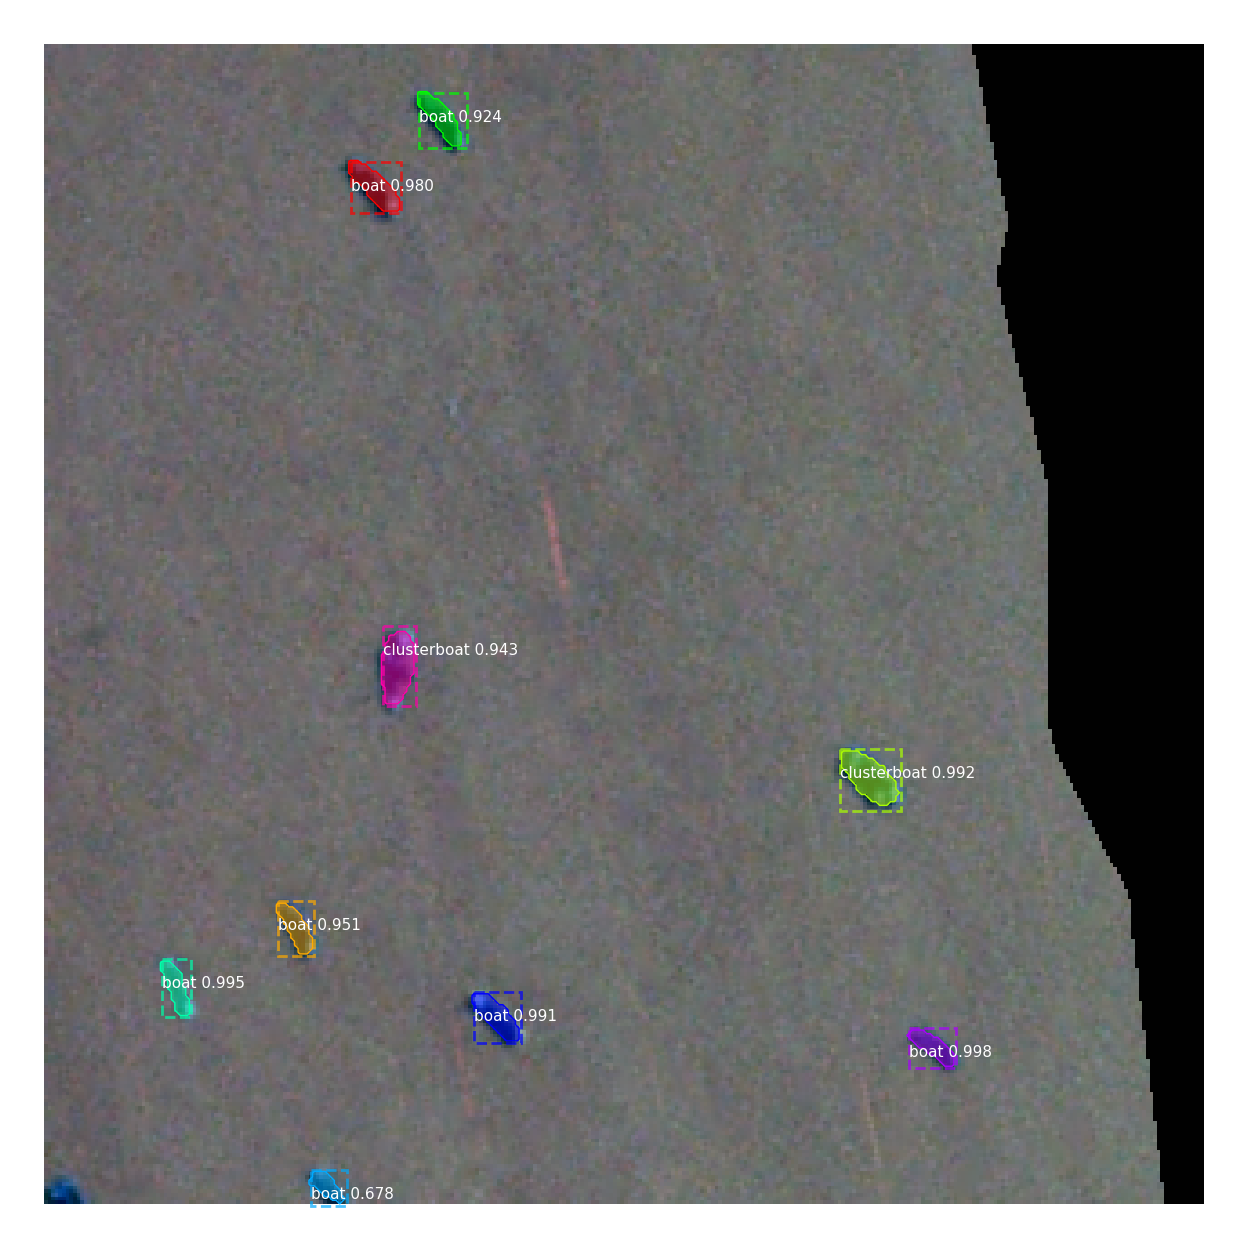

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


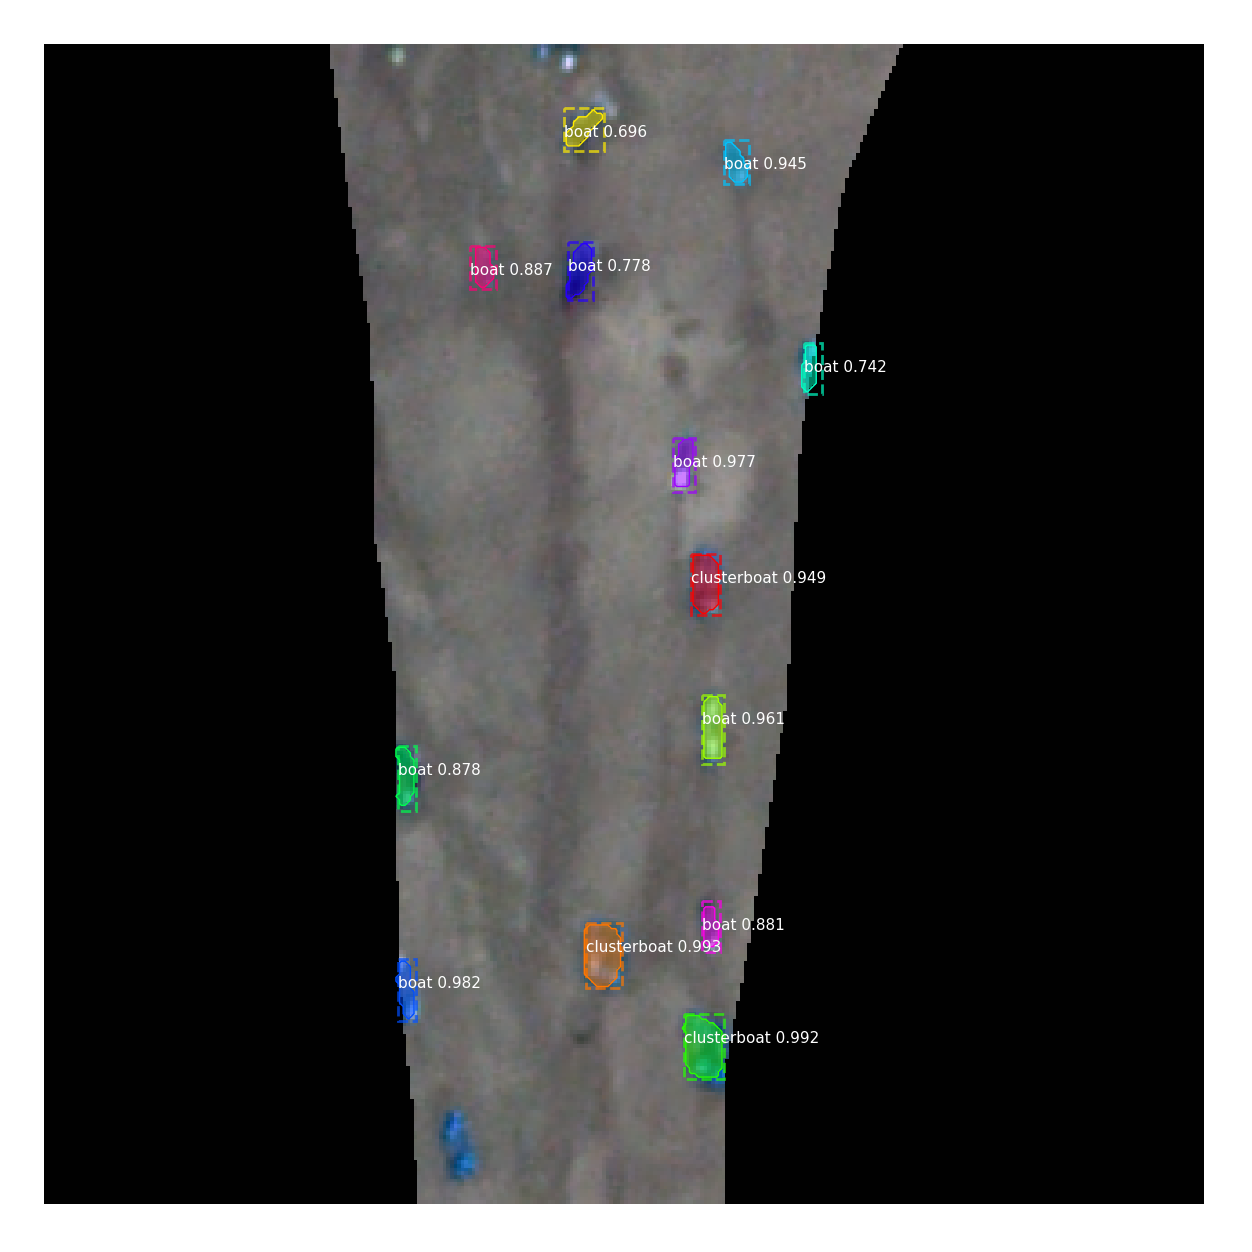

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


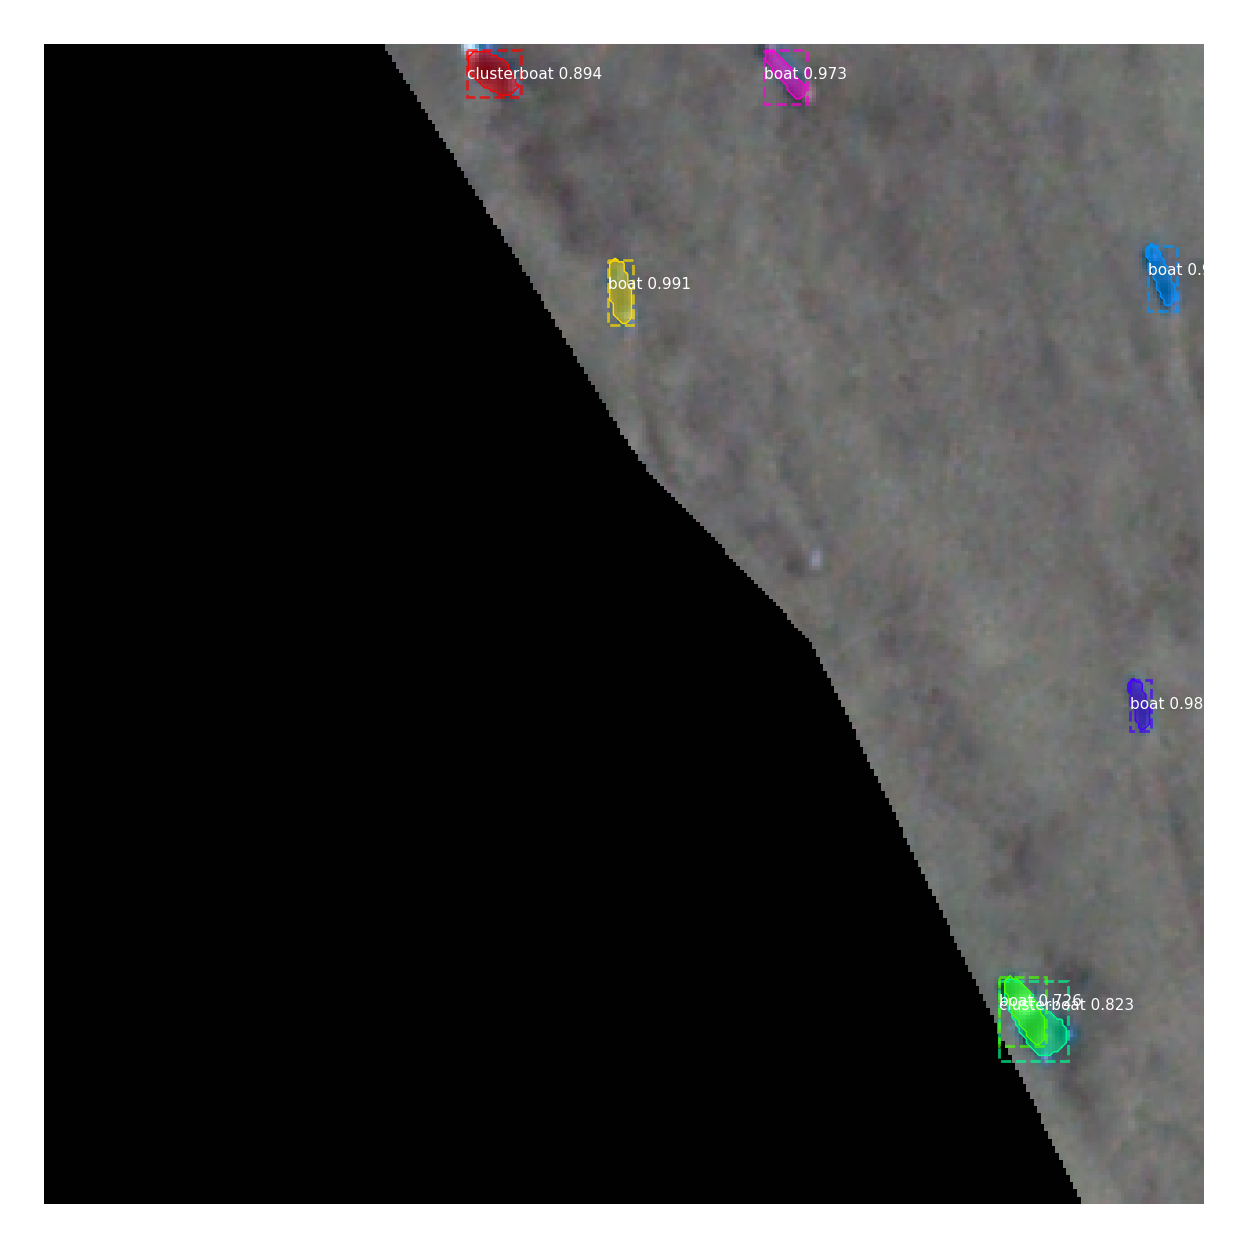

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


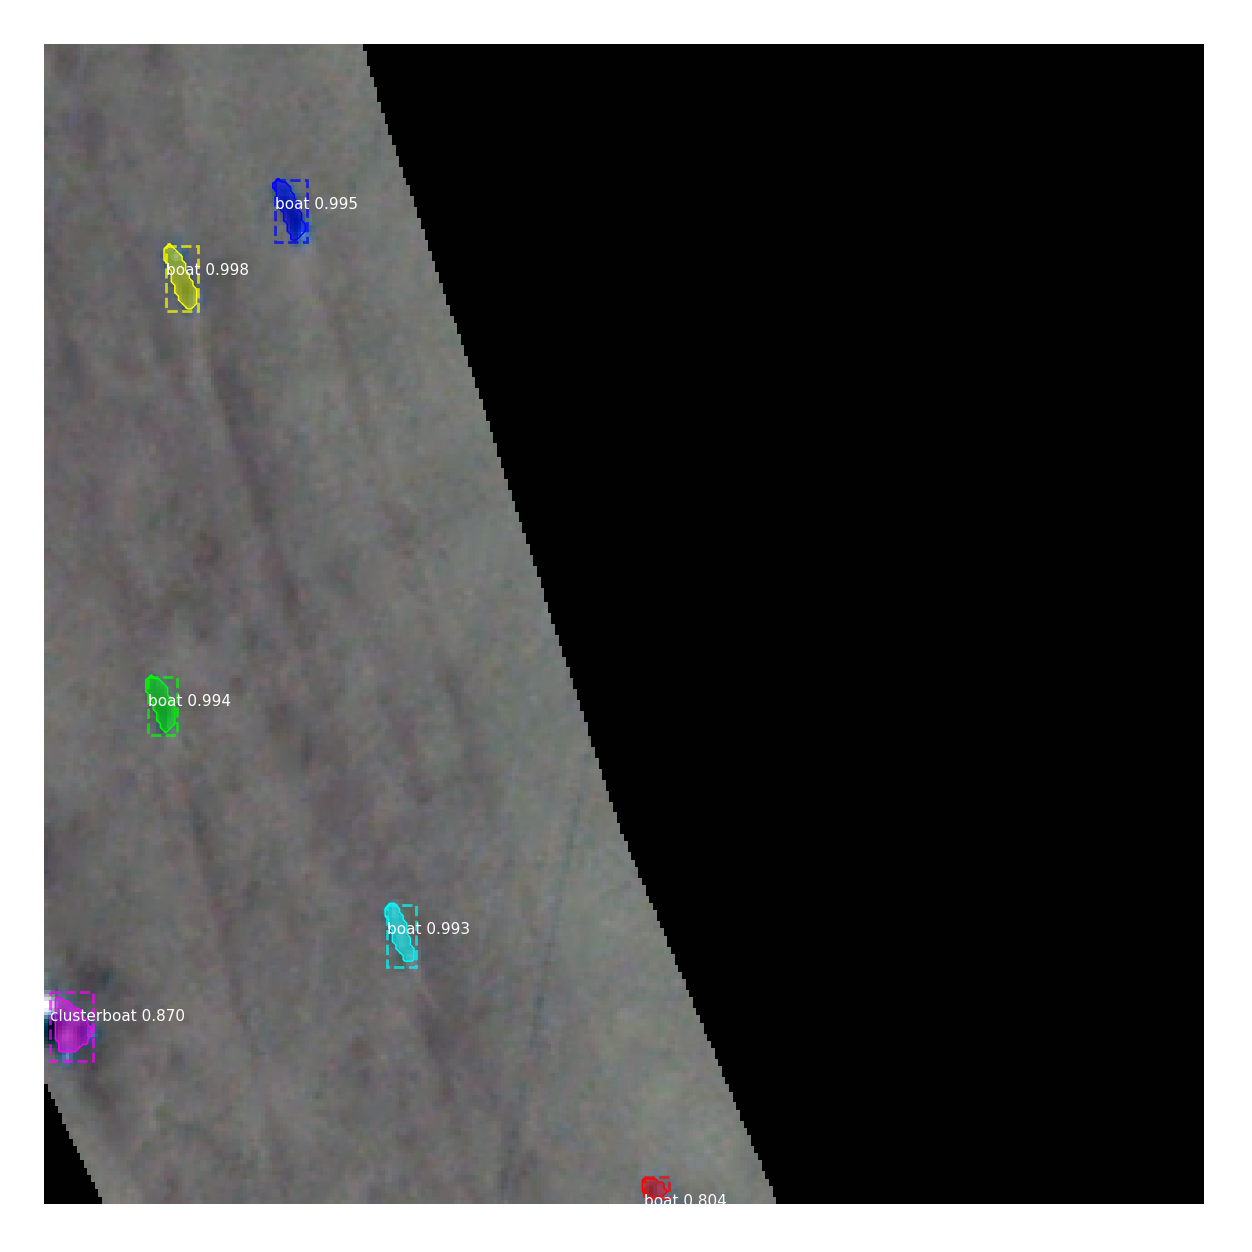

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


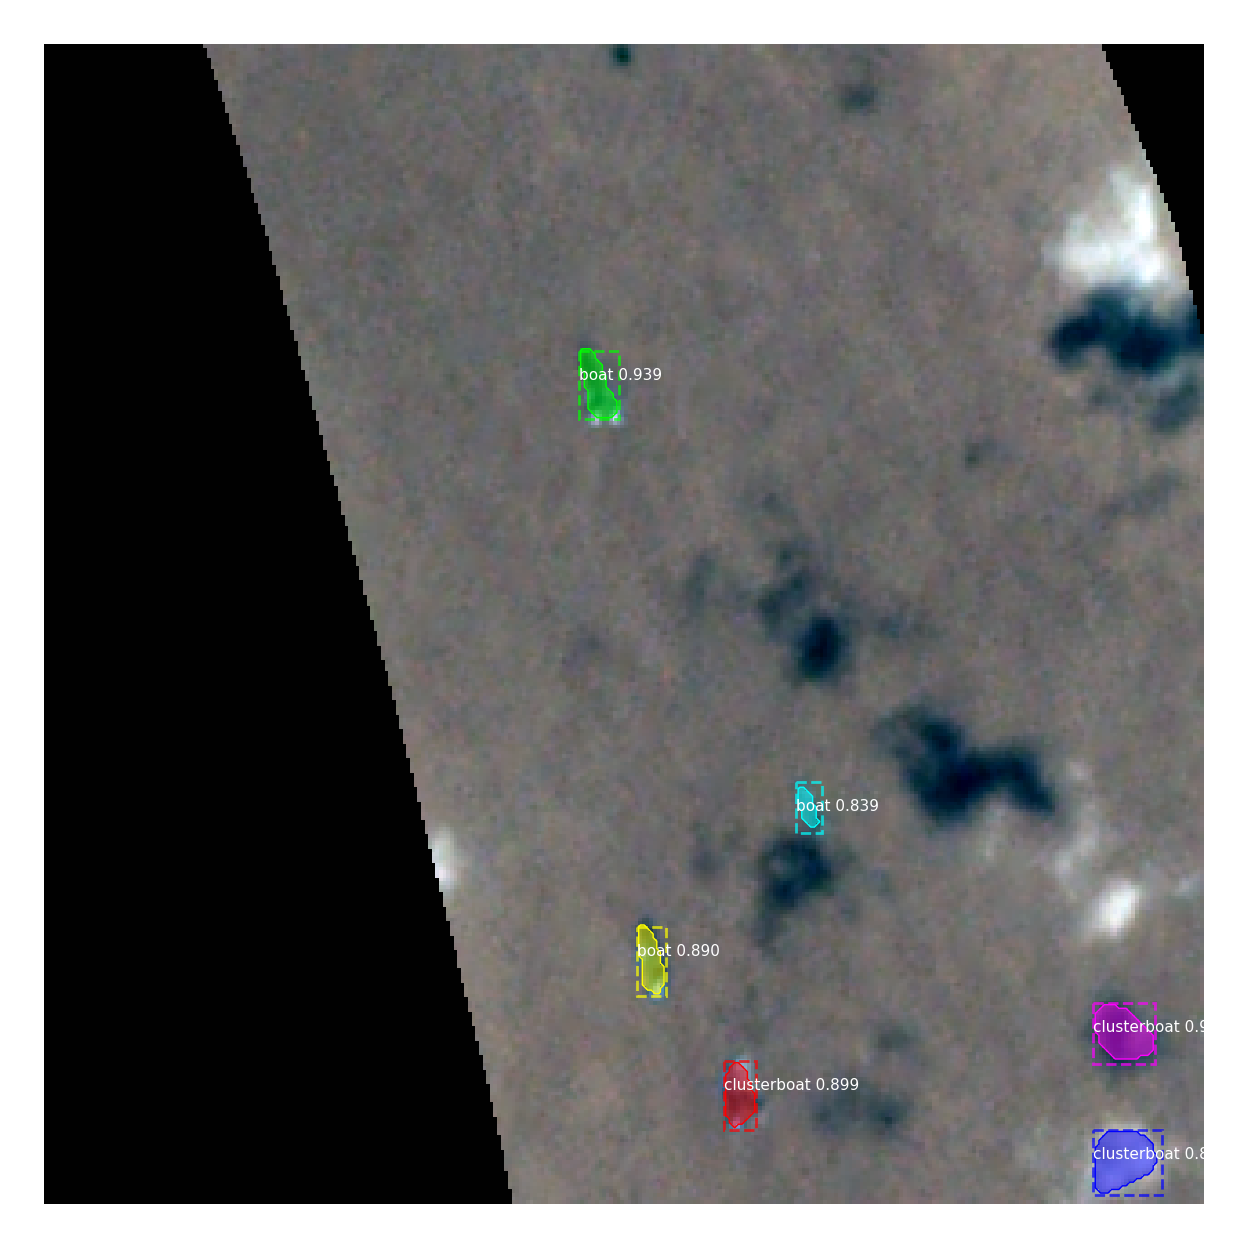

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


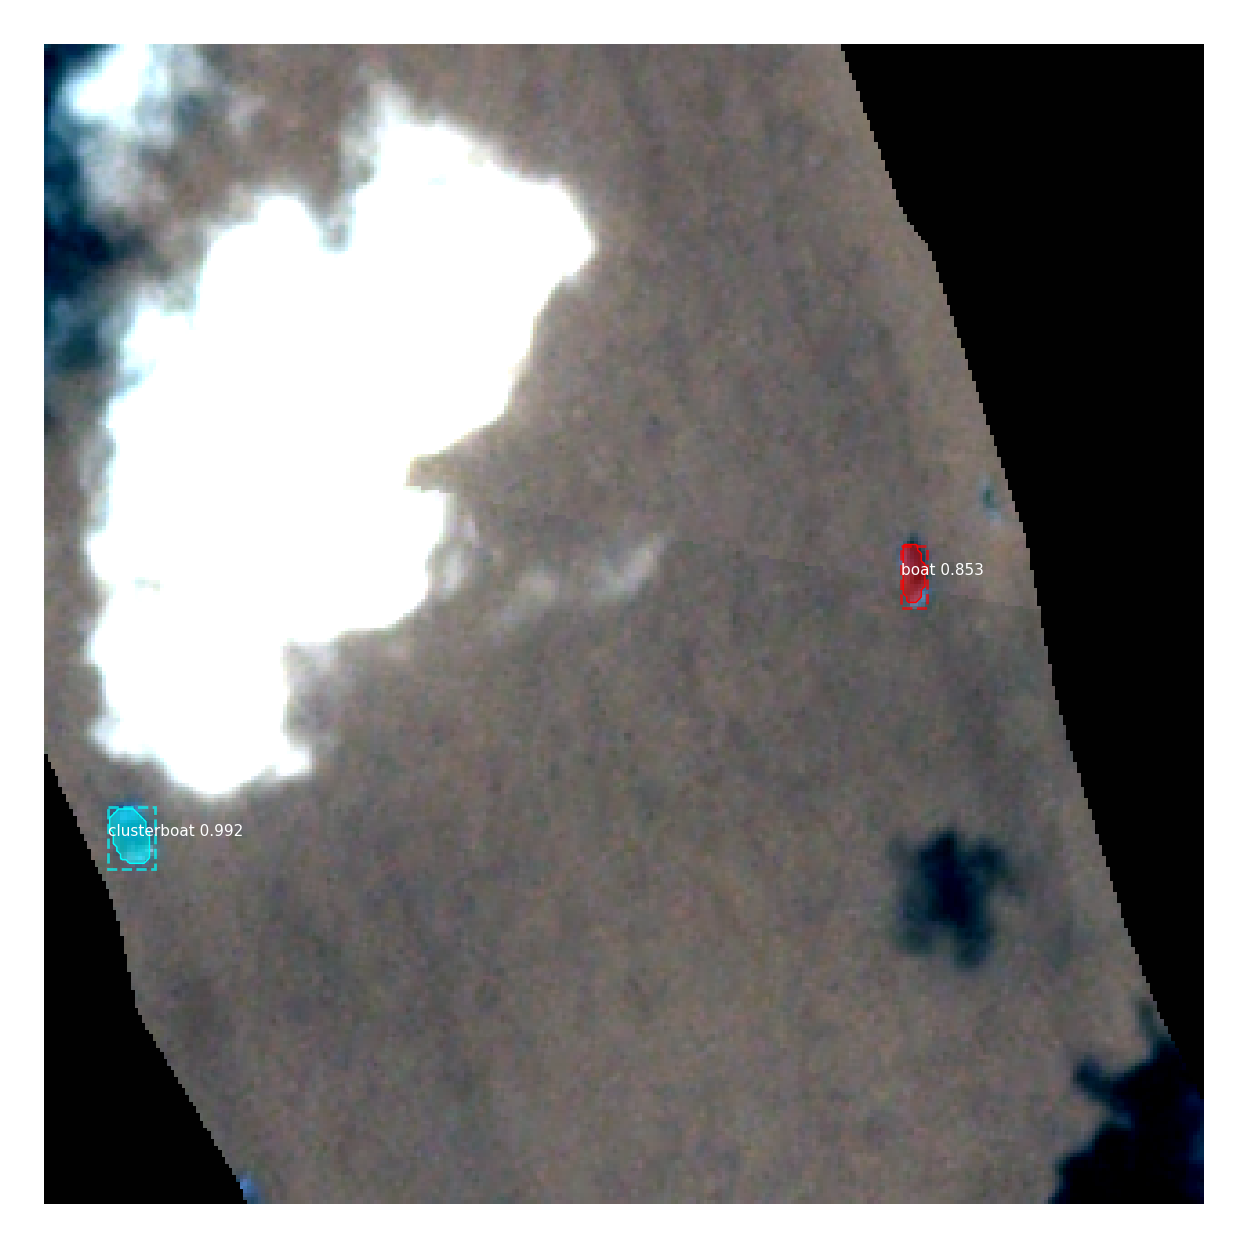

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  138.20000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


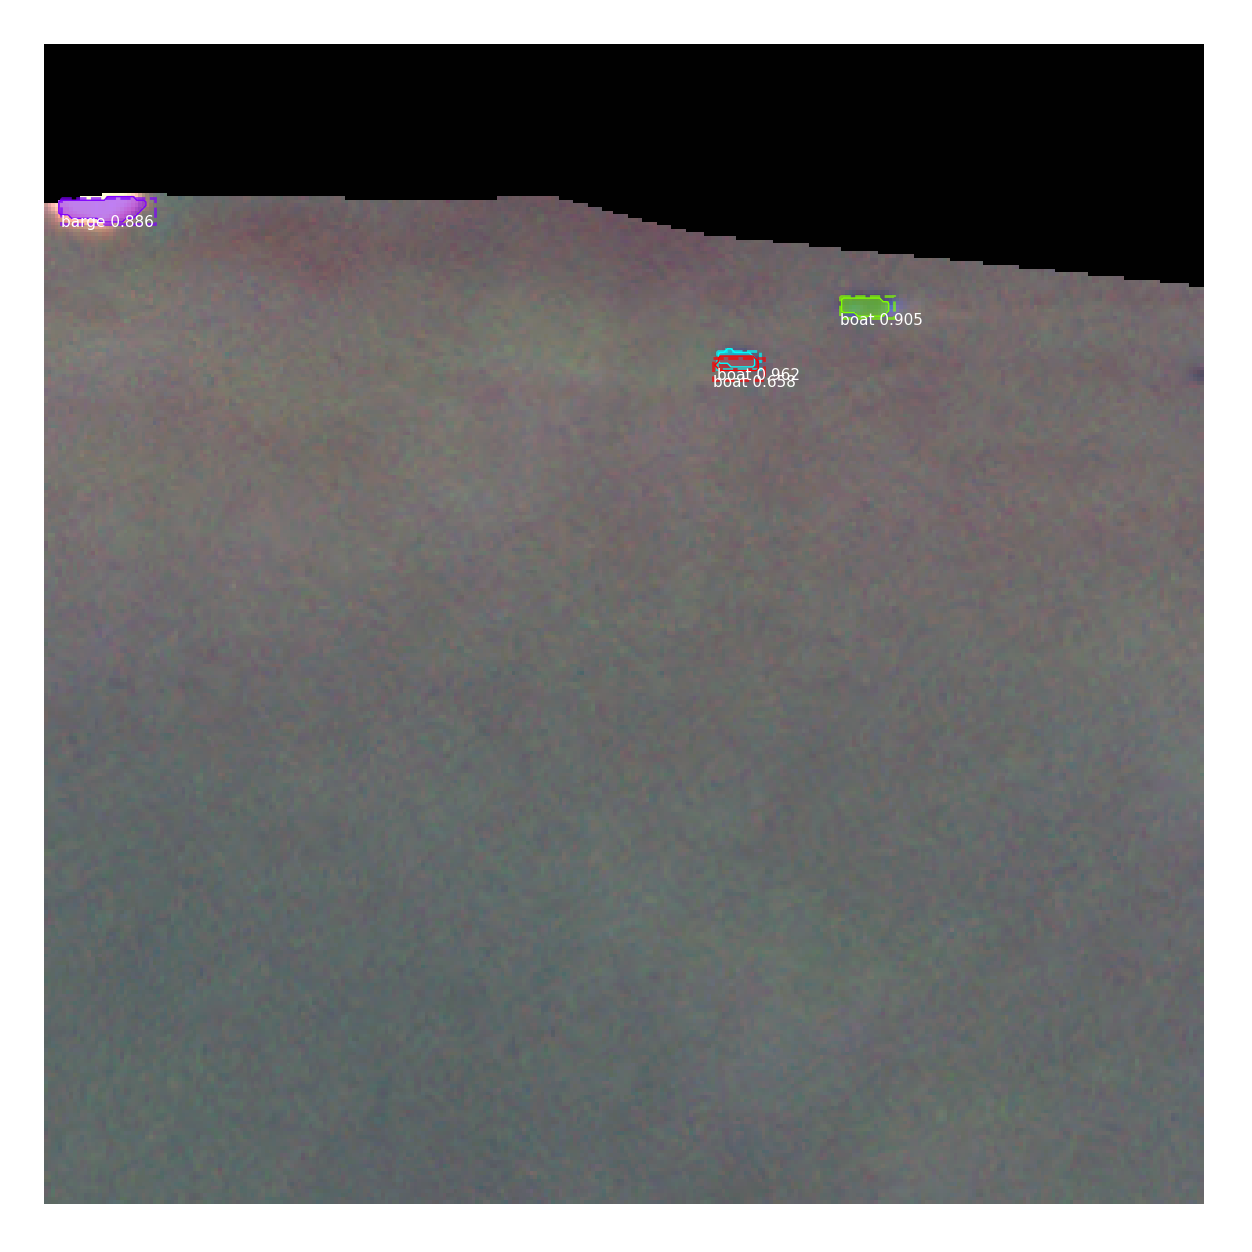

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


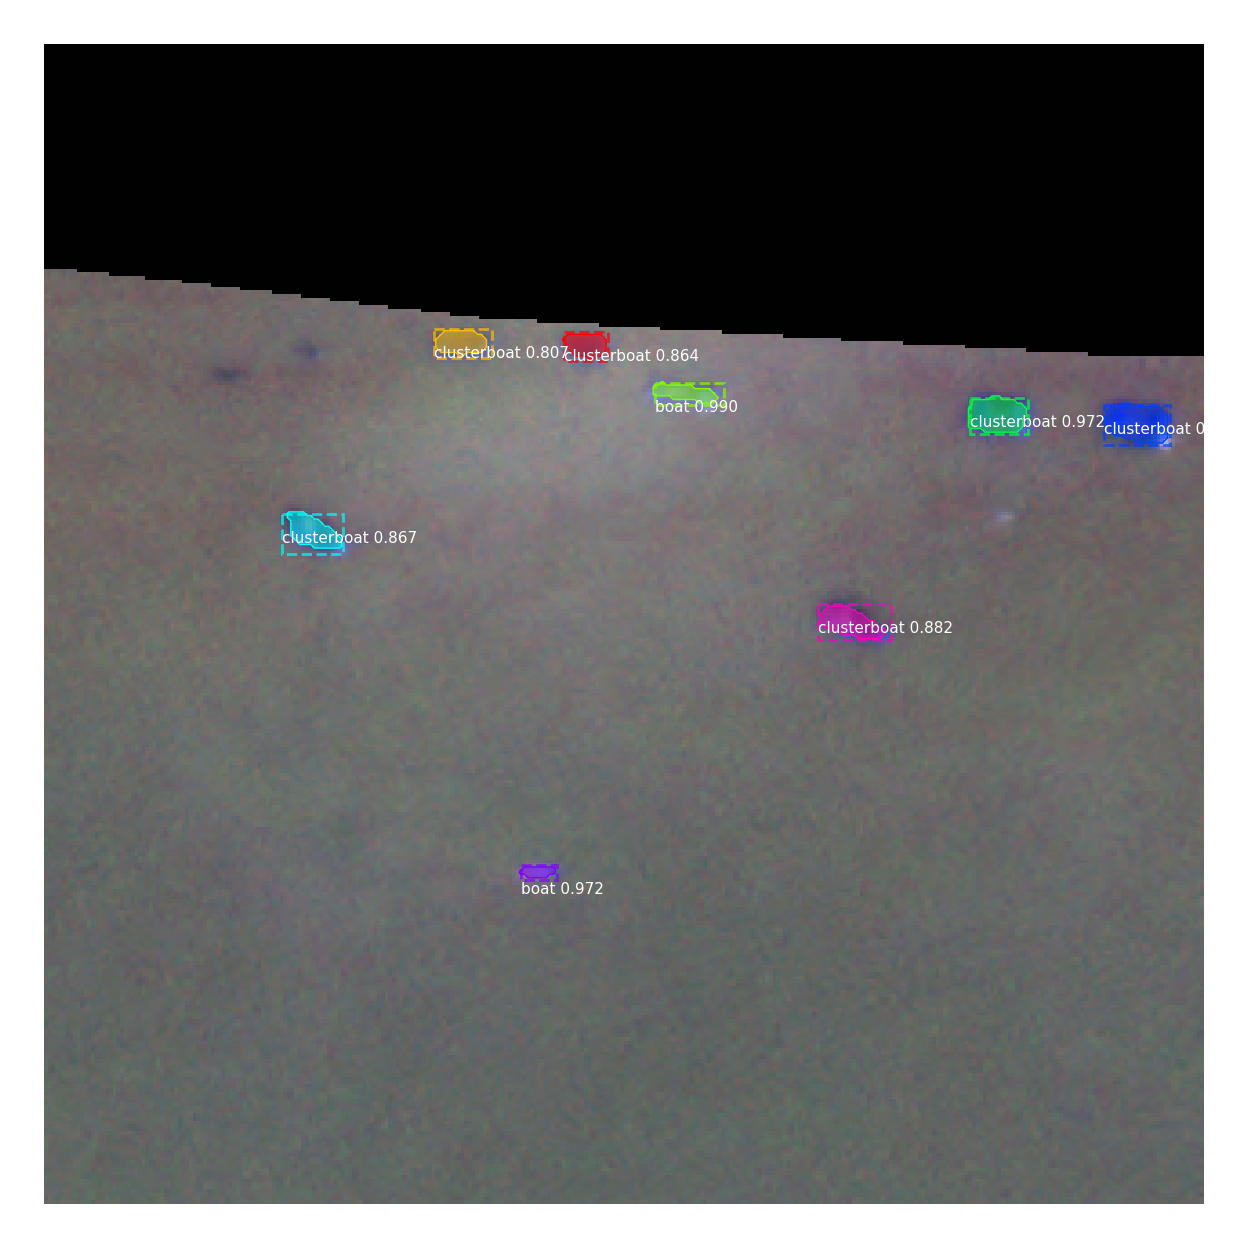

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  240.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:  136.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


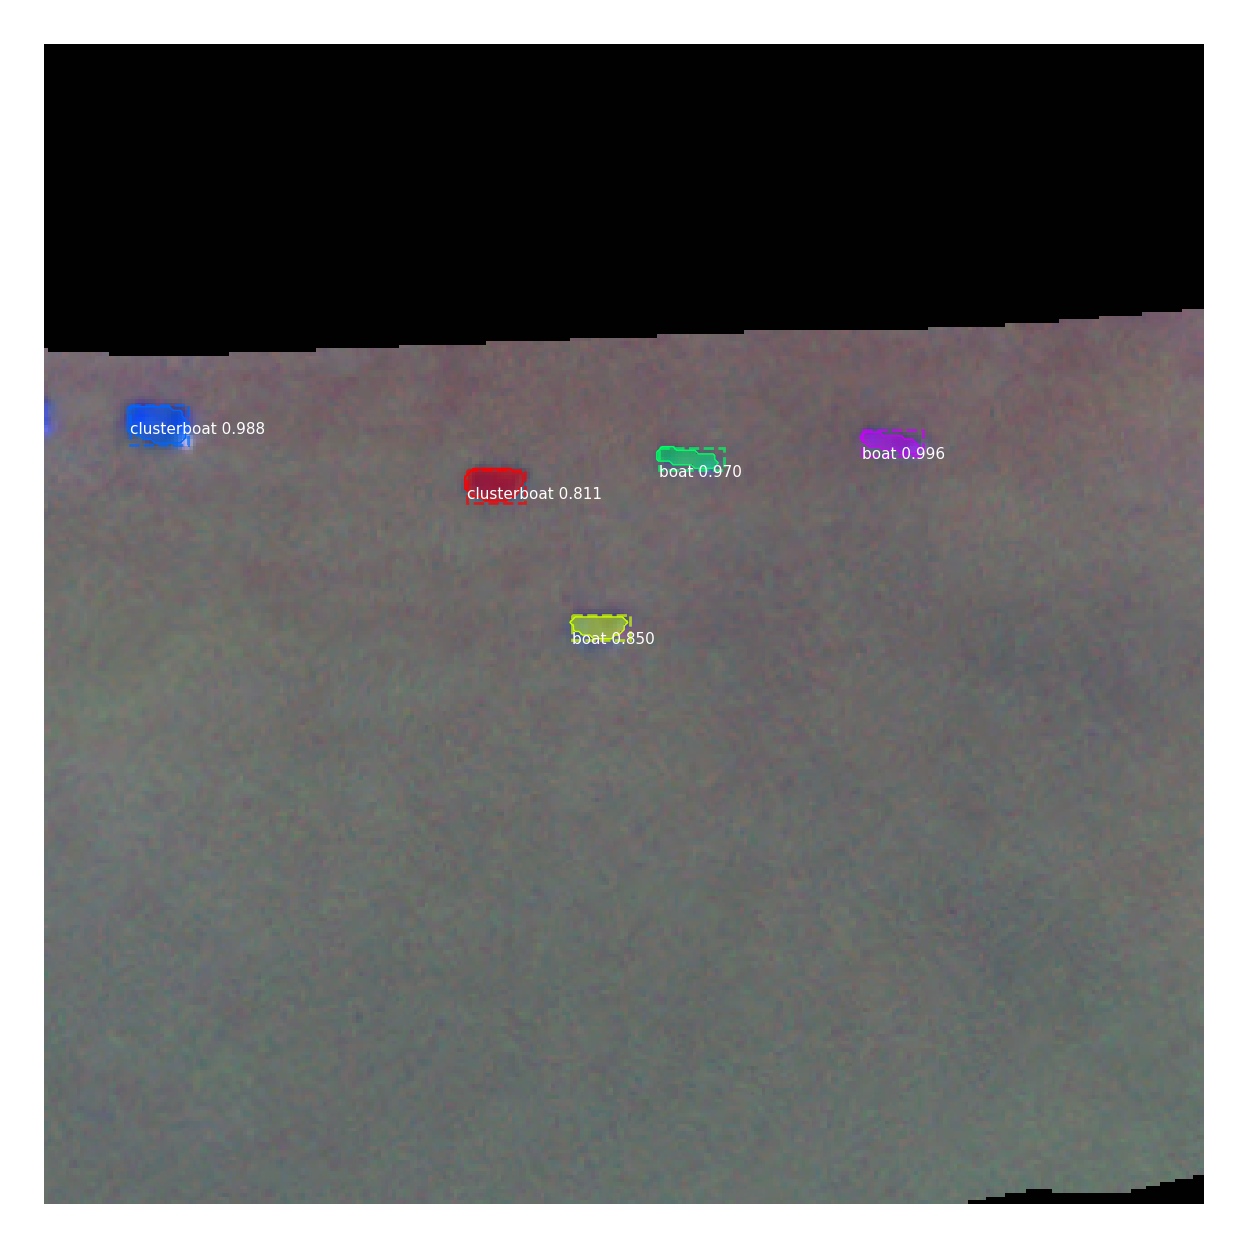

Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


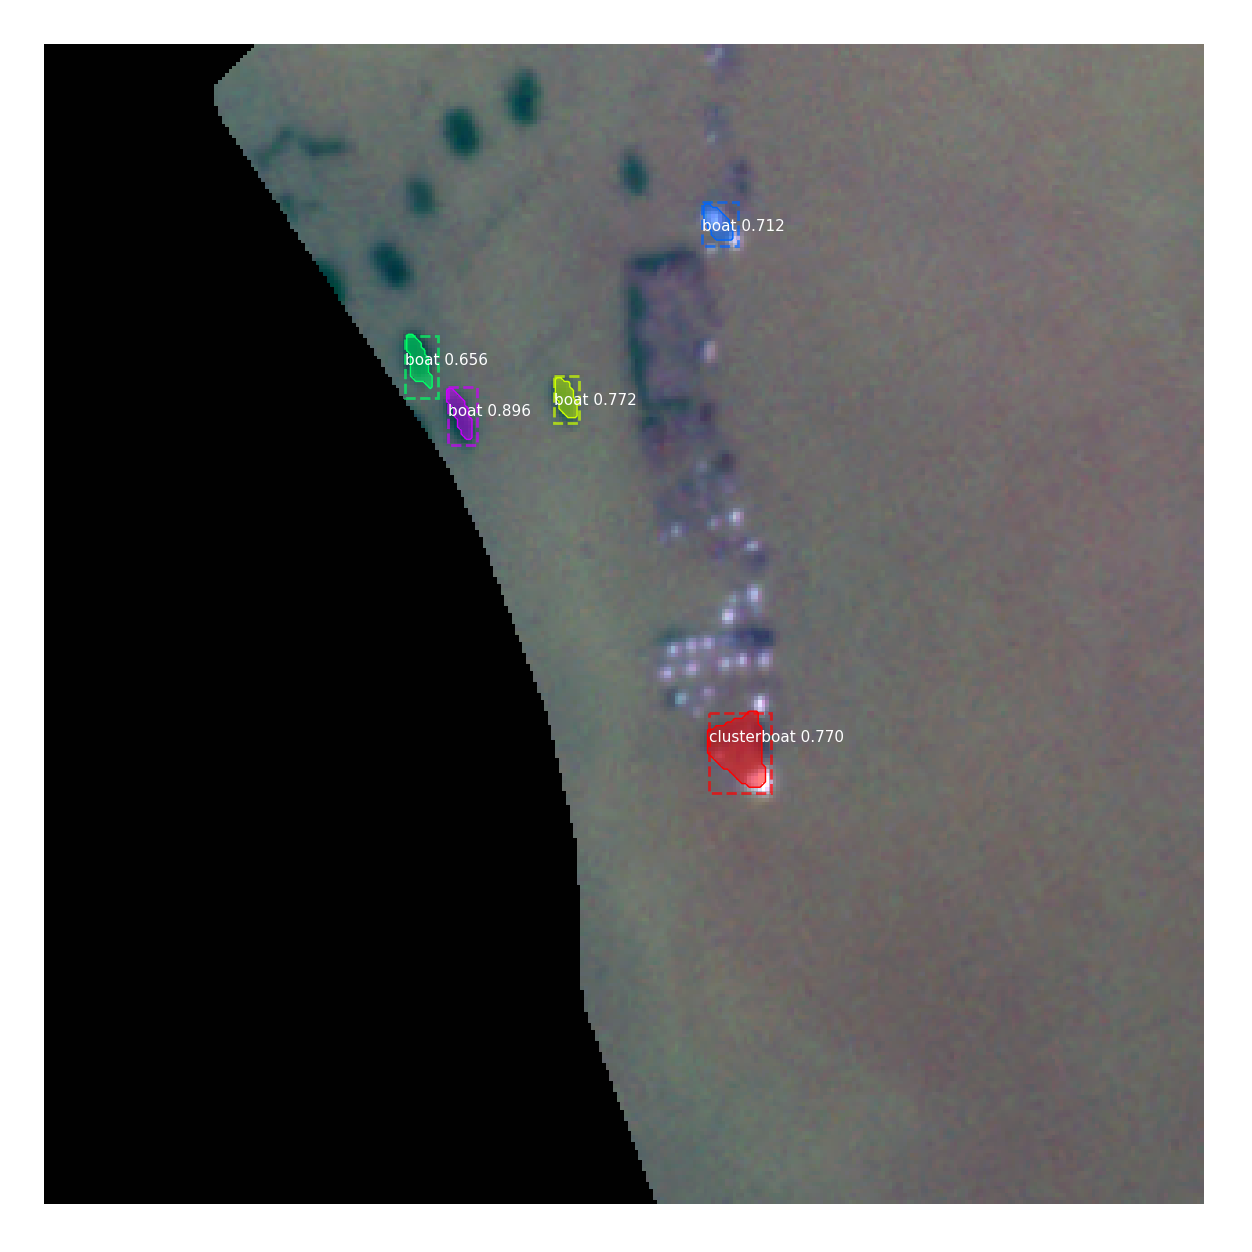

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.00000  max:  188.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -122.70000  max:   84.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


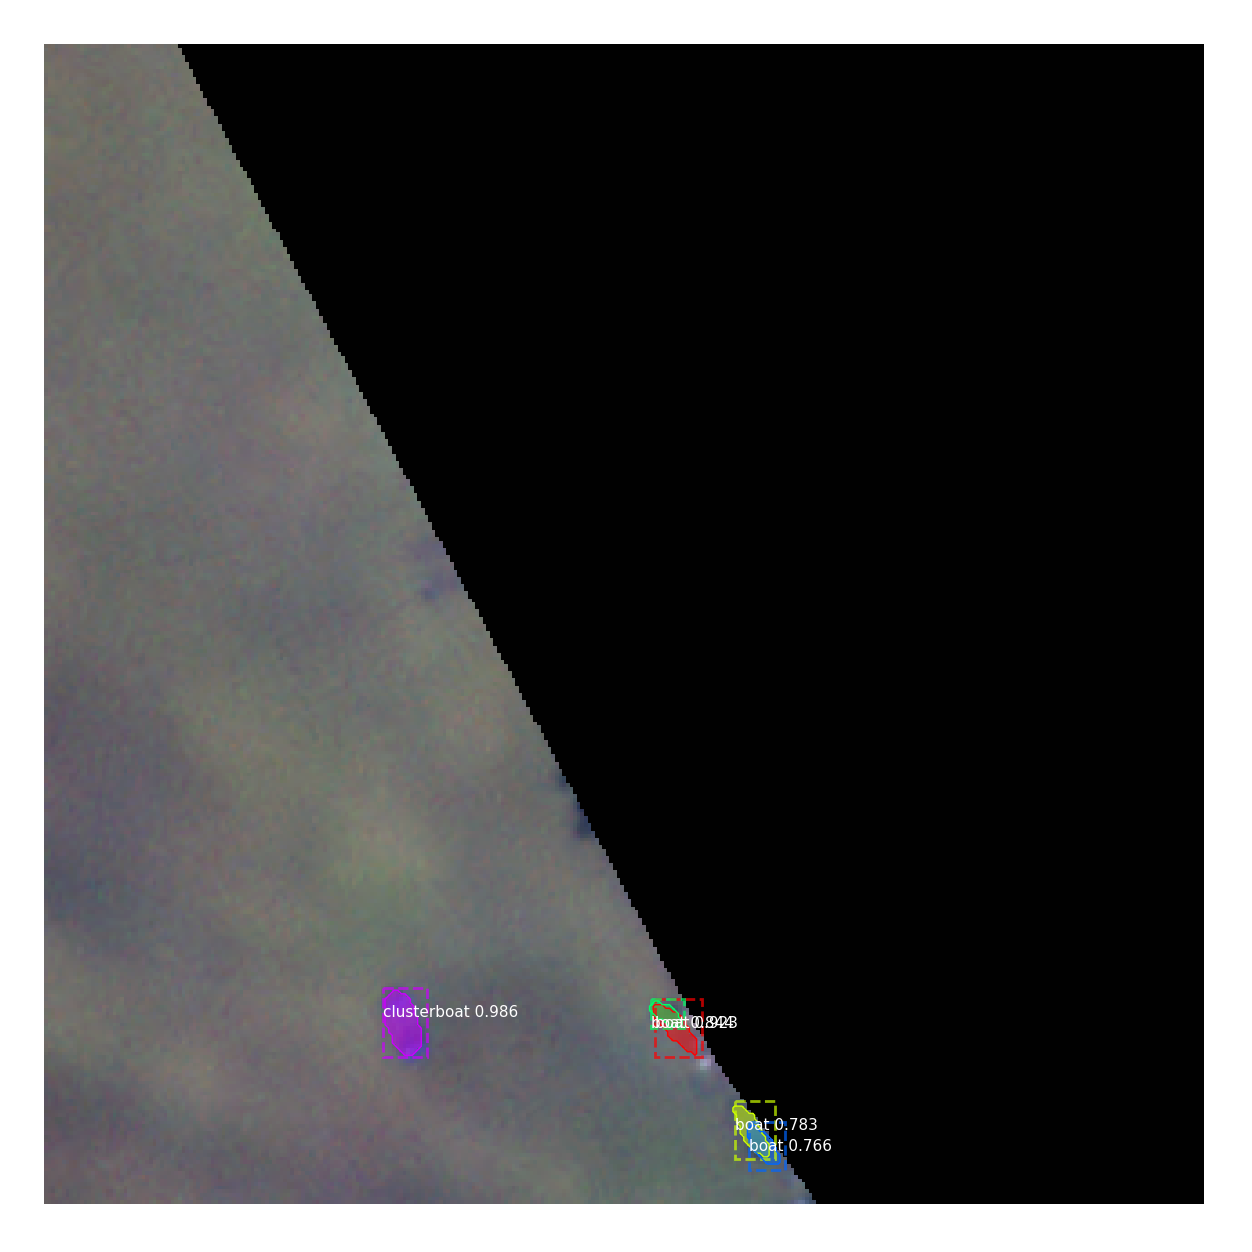

In [24]:
# Test the model on test dataset
import skimage
real_test_dir = 'E:/Anaconda/Mask_RCNN/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    pred = []
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    
    r = results[0]
    pred.append(r)
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'])

### Exporting the model predictions as binary masks

In [27]:
# Define the class IDs you want to export
class_ids_to_export = [1, 3]  # Boat and clusterboat classes

# Set 'sat_images' to image path that you want to perform the model on
sat_images = 'E:/Anaconda/Mask_RCNN/Sat_images/Outputs/Mekong_2021.12.30/tiles_PNG1'
image_paths = []
for filename in os.listdir(sat_images):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(sat_images, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    basename = os.path.basename(image_path) # Allows the image name to stay the same after the export
    results = model.detect([img_arr], verbose=0)
    masks = results[0]['masks']
    class_ids = results[0]['class_ids']
    
    filtered_masks = np.zeros_like(masks)
    for i in range(len(class_ids)):
        if class_ids[i] in class_ids_to_export:
            filtered_masks[:, :, i] = masks[:, :, i]
    
    if np.sum(filtered_masks) > 0:
        binary_mask = np.sum(filtered_masks, axis=2)
        # Convert the binary mask to an integer data type
        binary_mask = binary_mask.astype(np.uint8) * 255
        # Export the binary mask with the same input image name
        skimage.io.imsave(f'E:/Anaconda/Mask_RCNN/Output/boats_binary_output/{basename}', binary_mask)
    else:
        print("No masks detected in this image for the boat and clusterboat classes:", basename)
        
# Define the class IDs you want to export
class_ids_to_export_barge = [2]  # Barge class

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    basename = os.path.basename(image_path) # Allows the image name to stay the same after the export
    results = model.detect([img_arr], verbose=0)
    masks = results[0]['masks']
    class_ids = results[0]['class_ids']
    
    filtered_masks = np.zeros_like(masks)
    for i in range(len(class_ids)):
        if class_ids[i] in class_ids_to_export_barge:
            filtered_masks[:, :, i] = masks[:, :, i]
    
    if np.sum(filtered_masks) > 0:
        binary_mask = np.sum(filtered_masks, axis=2)
        # Convert the binary mask to an integer data type
        binary_mask = binary_mask.astype(np.uint8) * 255
        # Export the binary mask with the same input image name
        skimage.io.imsave(f'E:/Anaconda/Mask_RCNN/Output/barges_binary_output/{basename}', binary_mask)
    else:
        print("No masks detected in this image for the barge class:", basename)


No masks detected in this image for the boat and clusterboat classes: Mekong_2021.12.30_2431_merge_03_03_RGB.png


C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_04_01_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_04_02_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_04_03_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_05_01_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Me

No masks detected in this image for the boat and clusterboat classes: Mekong_2021.12.30_2431_merge_08_01_RGB.png


C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_09_04_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_09_05_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_10_02_RGB.png is a low contrast image


No masks detected in this image for the boat and clusterboat classes: Mekong_2021.12.30_2431_merge_10_04_RGB.png


C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_10_05_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_11_03_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_11_05_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Mekong_2021.12.30_2431_merge_11_06_RGB.png is a low contrast image
C:\Users\Fenna\anaconda3\envs\oefening2\lib\site-packages\ipykernel_launcher.py:33: UserWarning: E:/Anaconda/Mask_RCNN/Output/boats_binary_output/Me

No masks detected in this image for the boat and clusterboat classes: Mekong_2021.12.30_2431_merge_13_05_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_02_01_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_02_02_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_03_01_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_03_02_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_03_03_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_04_01_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_04_02_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_04_03_RGB.png
No masks detected in this image for the barge class: Mekong_2021.12.30_2431_merge_05_01_RGB.png
No masks detected in th

Sources that I used:
https://github.com/akTwelve/tutorials/blob/master/mask_rcnn/MaskRCNN_TrainAndInference.ipynb
https://github.com/matterport/Mask_RCNN/blob/master/samples/balloon/balloon.py
https://github.com/matterport/Mask_RCNN.git